# Банки — Анализ оттока клиентов
### Материалы
* [Презентация](https://disk.yandex.ru/i/6CyDNHH2DUm_ww)
* [Дашборд](https://public.tableau.com/profile/galaleksey#!/vizhome/Project_12_Banks/Dashboard)

### Описание проекта
**Заказчик**: менеджер продукта в региональном банке, которому требуется разработать меры по удержанию клиентов.

**Основная задача** - проанализировать данные клиентов банка и выделить портрет клиентов, которые склонны уходить из банка.

### Содержание
[1. Предобработка данных](#h1_1)
    * Проверка корректности наименований колонок;
    * Поиск пропущенных значений;
    * Исследование соответствия типов;
    * Поиск дубликатов;
    * Выводы по шагу.
[2. Исследовательский анализ данных](#h1_2)
    * Изучение средних значений и стандартных отклонений параметров;
    * Изучение распределений признаков;
    * Корреляционный анализ признаков;
    * Выводы по шагу.
[3. Анализ оттока и построение портрета клиентов](#h1_3)
    * Изучение средних значений и распределений признаков для тех, кто ушёл в отток и тех, кто остался;
    * Анализ основных признаков, наиболее сильно влияющих на отток;
    * Выделение основных групп клиентов и их свойств;
    * Выводы по шагу.
[4. Формулировка и проверка гипотез](#h1_4)
    * Обязательная гипотеза для проверки: есть ли различие дохода между теми клиентами, которые ушли и теми, которые остались;
    * Выводы по шагу.
[5. Кластеризация клиентов](#h1_5)
    * Проведение кластеризации клиентов методами ML;     
    * Построение распределений признаков для полученных кластеров;
    * Выводы по шагу.
[6. Выводы](#h1_6)
    * Предложения по улучшению стратегии взаимодействия с клиентами и их удержанию
[7. Подготовка презентации](#h1_7)

[8. Подготовка дашборда](#h1_8)
    
### Описание данных
- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента (оценочная),
- `Churn` — ушёл или нет.

### Модули и общие функции для работы с данными

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import statistics as st
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

#отключение предупреждений
warnings.filterwarnings('ignore')


def print_hist(data, title, x, y, bins_count=100, size=(10,5)):
    """Функция для вывода гистограммы на экран. Параметры:
        data - датафрейм или колонка
        bins_count - число корзин гистограммы
        size - размер рисунка
        title - заголовок гистограммы
        x - название оси абсцисс
        y - названи оси ординат
    """
    with plt.style.context('seaborn'):
        data.hist(bins = bins_count, figsize=size)
        plt.grid(True)
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()
        
def print_plot(data, plot_kind, title, x, y, size=(10,5), annotate=True):
    """Функция для вывода графика на экран. Параметры:
        data - датафрейм или колонка
        bins_count - число корзин гистограммы
        size - размер рисунка
        title - заголовок гистограммы
        x - название оси абсцисс
        y - названи оси ординат
        annotate - опция для вывода над колонками долей от общего цисла (в процентах)
    """
    with plt.style.context('seaborn'):
        ax = data.plot(kind=plot_kind, stacked=False, figsize=size)
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.xticks(rotation=0)
        if annotate == True:
            total = 0
            for p in ax.patches:
                total += p.get_height()
            for p in ax.patches:
                percentage = '{:.0f}%'.format(100 * p.get_height()/total)
                xl = p.get_x() + p.get_width()/2.
                yl = p.get_y() + p.get_height()
                ax.annotate(percentage, (xl, yl), xytext=(0, 3), textcoords='offset points', horizontalalignment='center')
        plt.show()
        
def stat_ttest(df1,df2, alpha=0.05):
    """Функция для проведения статистического теста
    df1,df2 - наборы данных для проведения теста
    alpha - критический уровень статистической значимости
    """

    # Проведение теста Левина и расчет p-значения
    results_var_test = st.levene(df1, df2, center='mean')

    # Вывод на экран полученного p-значения для теста Левина
    print('p-значение для теста Левина: ', results_var_test.pvalue)

    # Сравнение получившееся p-значение с заданным уровнем статистической значимости:
    if (results_var_test.pvalue < alpha):     
        print("Отвергаем гипотезу о равенстве дисперсий сравниваемых выборок.")
        equal_var_test = True
    else:
        print("Не получилось отвергнуть гипотезу о равенстве дисперсий сравниваемых выборок.")
        equal_var_test = False
        
    # Проведение статистического теста и расчет p-значения
    results = st.ttest_ind(
        df1,
        df2,
        equal_var = equal_var_test)

    # Вывовд на экран полученного p-значения t-теста
    print('p-значение для t-теста: ', results.pvalue)

    # Сравним получившееся p-значение с заданным уровнем статистической значимости:
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [2]:
# Открытие файла и создание датафрейма
try:
    df = pd.read_csv('/datasets/bank_dataset.csv')
except:
    df = pd.read_csv('bank_dataset.csv')

Посмотрим общую информацию и примеры данных:

In [3]:
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1


По общей информации и примерам данных видно, что:
* названия колонок указаны в разных стилях;
* в колонке `Balance` имеются пропущенные значения;
* типы данных выглядят корректно.

Для удобства последующей работы переименуем названия колонок в нижний регистр:

In [4]:
df.columns = df.columns.str.lower()

Посмотрим, есть ли в данных дубликаты:

In [5]:
print('Количество дублей в данных: {}'.format(df.duplicated().sum()))

Количество дублей в данных: 0


### Выводы по шагу 1
1. Данные загружены в датафрейм. В исходном датасете достаточно много записей.
1. Обнаружены пропущенные значения в колонке `balance`. Мы посмотрим детальнее данные значения на этапе исследовательского анализа данных и после этого решим, что с ними делать.
1. Типы данных решено оставить без изменения.
1. Дублей в данных не найдено.
1. Названия колонок переименованы в нижний регистр.


## 2. Исследовательский анализ данных<a class="anchor" id="h1_2"></a>
Для начала посмотрим подробнее на набор данных, рассчитав средние значения и стандартные отклонения.

In [6]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


* Для признака оценочной зарплаты (`estimated salary`) стандартное отклонение выглядит очень высоким.
* В балансе счета (`balance`) не встречается нулевых значений.

Далее рассмотрим подробнее каждый признак, построим для каждого из них гистограмму или столбчатую диаграмму (в зависимости от типа признака).

#### Город (`city`)

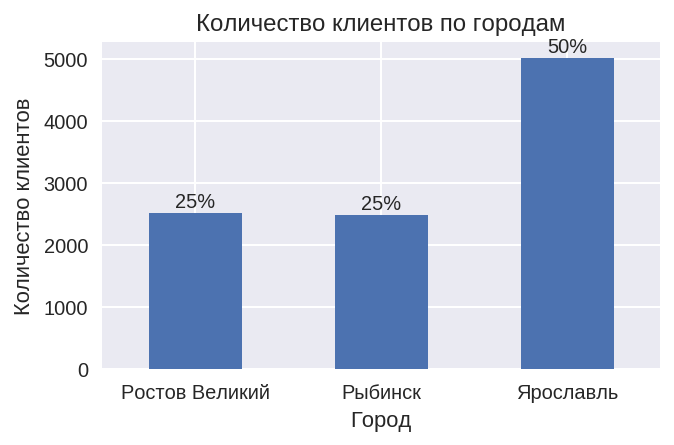

In [7]:
print_plot(df.groupby('city')['userid'].agg('count'), 'bar', 'Количество клиентов по городам', 'Город','Количество клиентов', (5,3))

* Всего в данных встречаются клиенты по трем городам.
* Клиентов по Ярославлю в данных в два раза больше, чем в каждом из других городов.

#### Пол (`gender`)

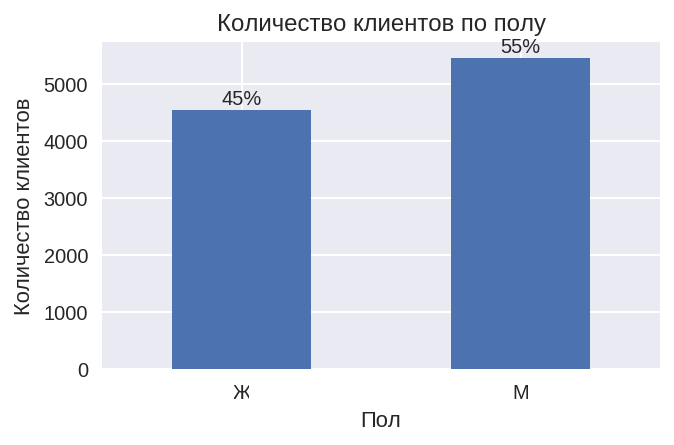

In [8]:
print_plot(df.groupby('gender')['userid'].agg('count'), 'bar', 'Количество клиентов по полу', 'Пол','Количество клиентов', (5,3))

Мужчин среди клиентов банка чуть больше, чем женщин.

#### Кредитный рейтинг (`score`)
Построим гистограмму распределения значений данного параметра:

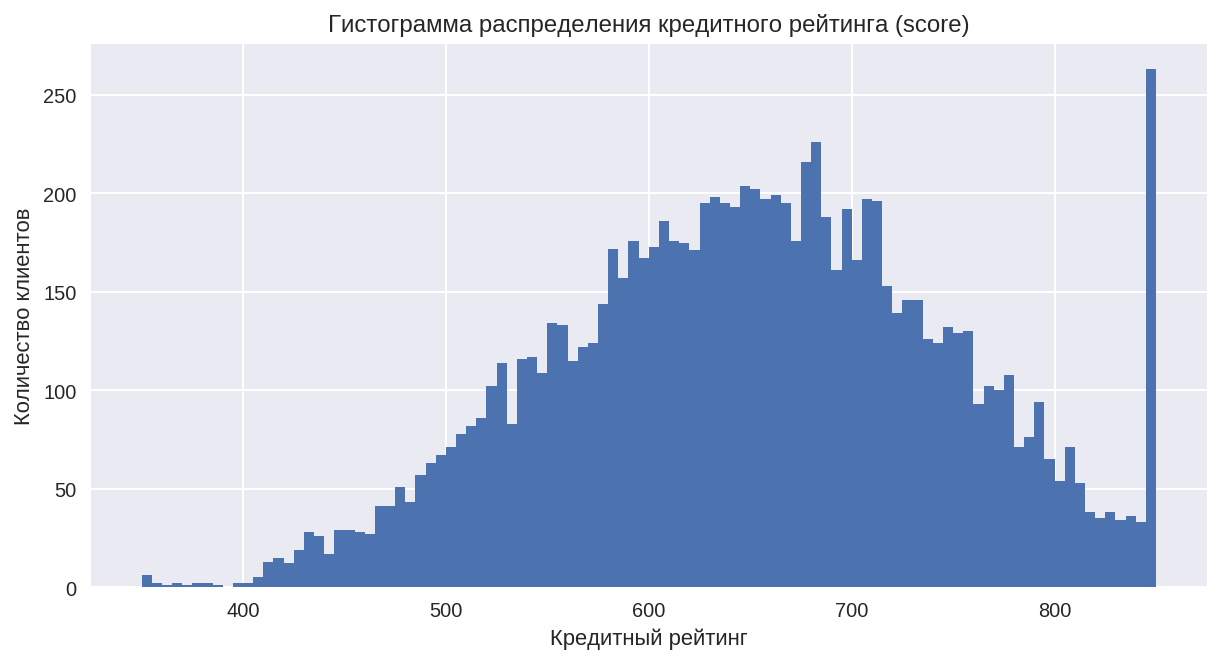

In [9]:
print_hist(df['score'], 'Гистограмма распределения кредитного рейтинга (score)', 'Кредитный рейтинг','Количество клиентов', 100)

Распределение похоже на нормальное, но в самом его хвосте имеется сильный всплеск: наибольшее значение рейтинга встречается у большого количества клиентов. Скорее всего оно, встречается в выборке чаще всех остальных. Проверим это:

In [10]:
print('Значение кредитного рейтнига, которое встречается чаще всего (мода): {}'.format(st.mode(df['score'])))

Значение кредитного рейтнига, которое встречается чаще всего (мода): ModeResult(mode=array([850]), count=array([233]))


Действительно, это наиболее популярное значение в наборе данных.

#### Возраст (`age`)

Посмотрим подробнее гистограмму распределения.

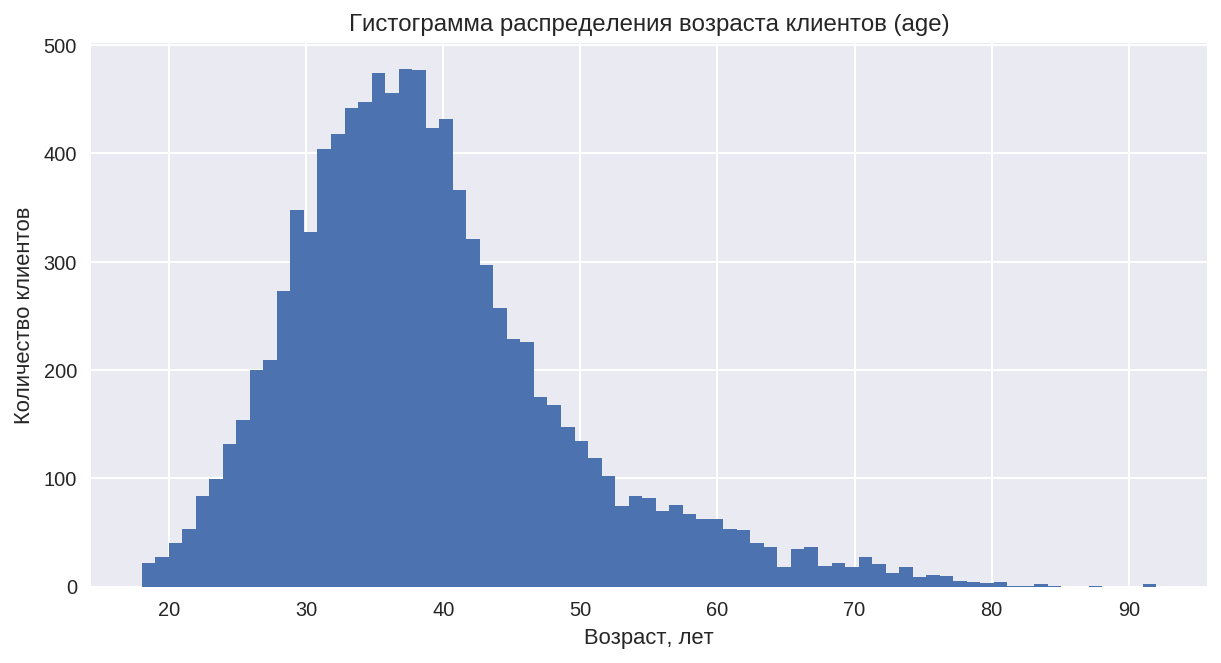

In [11]:
print_hist(df['age'], 'Гистограмма распределения возраста клиентов (age)', 'Возраст, лет','Количество клиентов', 75)

Распределение выглядит корректно. Наибольшее количество клиентов приходится на возраст примерно 37 лет.

#### Количество объектов в собственности (`objects`)

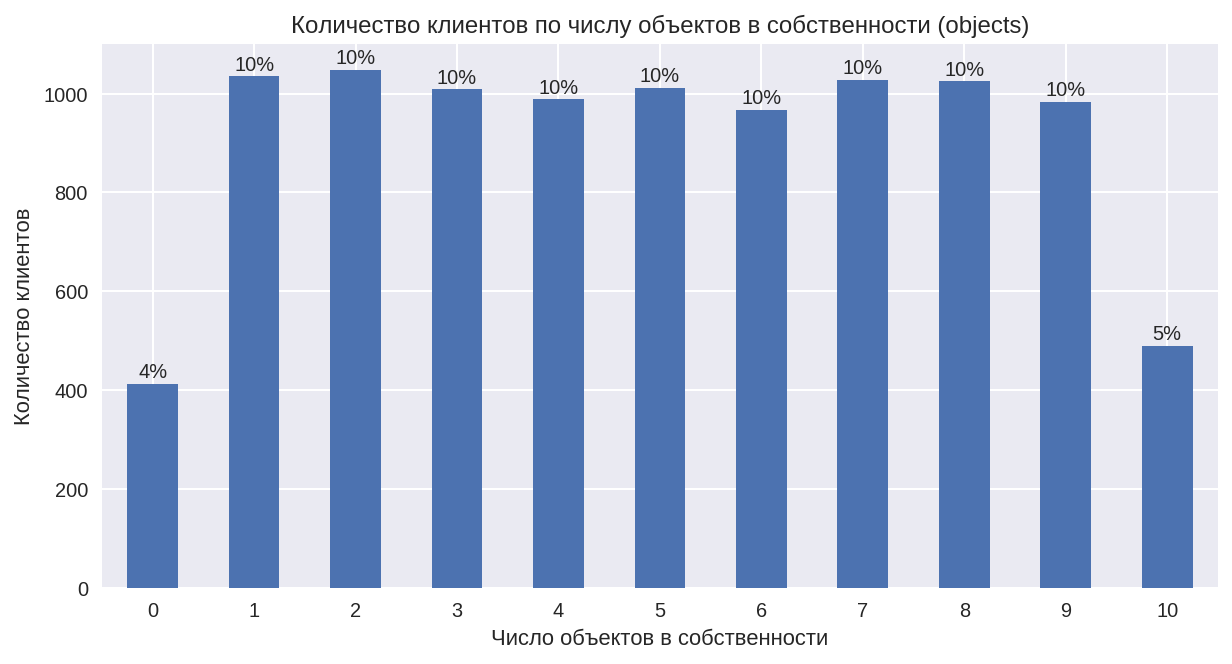

In [12]:
print_plot(df.groupby('objects')['userid'].agg('count'), 'bar', 'Количество клиентов по числу объектов в собственности (objects)', 'Число объектов в собственности','Количество клиентов')

Число объектов в собственности распределено достаточно равномерно. Меньше всего клиентов, у которых число объектов 0 и 10 (наименьшее и наибольшее значения).

#### Количество продуктов (`products`)

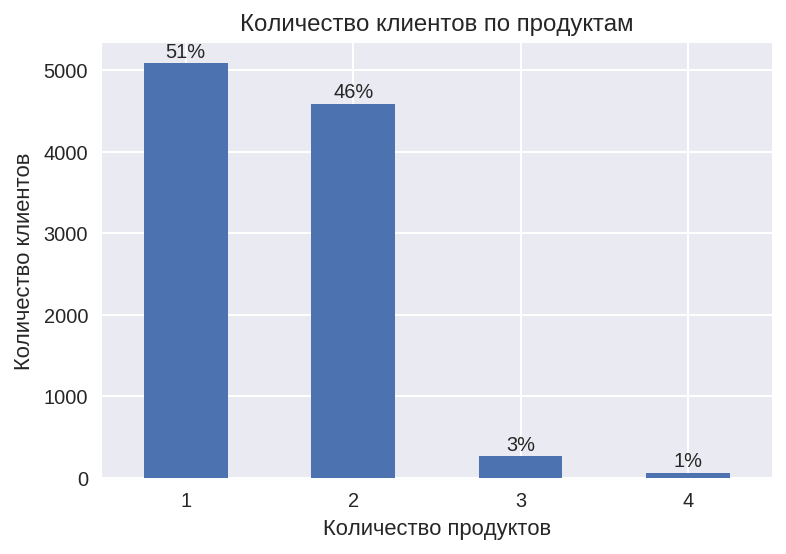

In [13]:
print_plot(df.groupby('products')['userid'].agg('count'), 'bar', 'Количество клиентов по продуктам', 'Количество продуктов','Количество клиентов', (6,4))

Из данной диаграммы можно сделать вывод, что подавляющее большинство клиентов банка пользуются всего одним или двумя продуктами.

#### Наличие кредитной карты (`creditcard`)

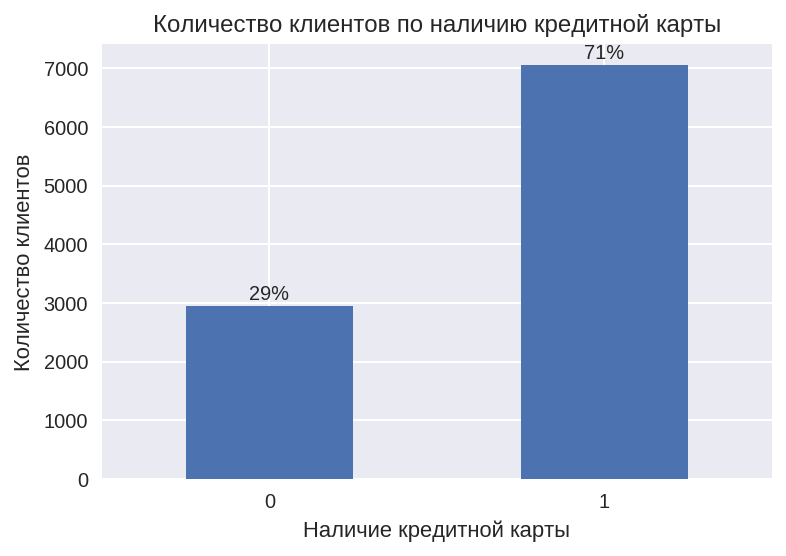

In [14]:
print_plot(df.groupby('creditcard')['userid'].agg('count'), 'bar', 'Количество клиентов по наличию кредитной карты', 'Наличие кредитной карты','Количество клиентов', (6,4))

#### Активный клиент (`loyalty`)

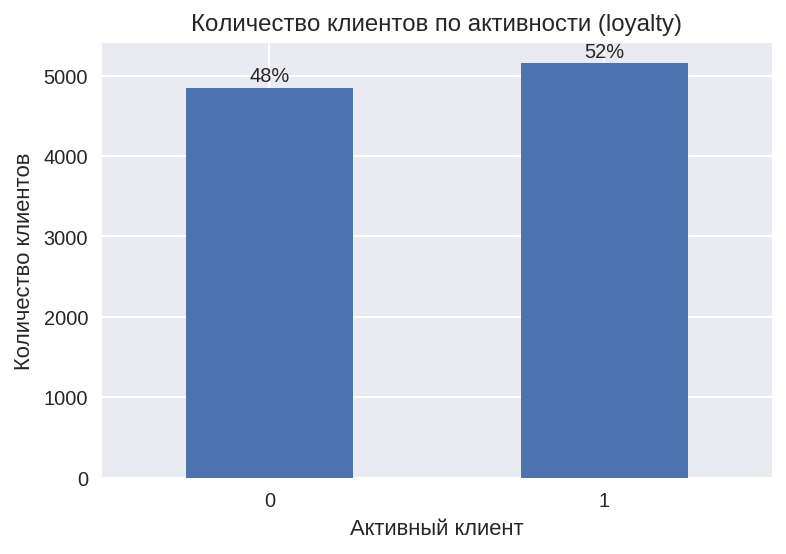

In [15]:
print_plot(df.groupby('loyalty')['userid'].agg('count'), 'bar', 'Количество клиентов по активности (loyalty)', 'Активный клиент','Количество клиентов', (6,4))

#### Оценочная заработная плата клиента (`estimated_salary`)

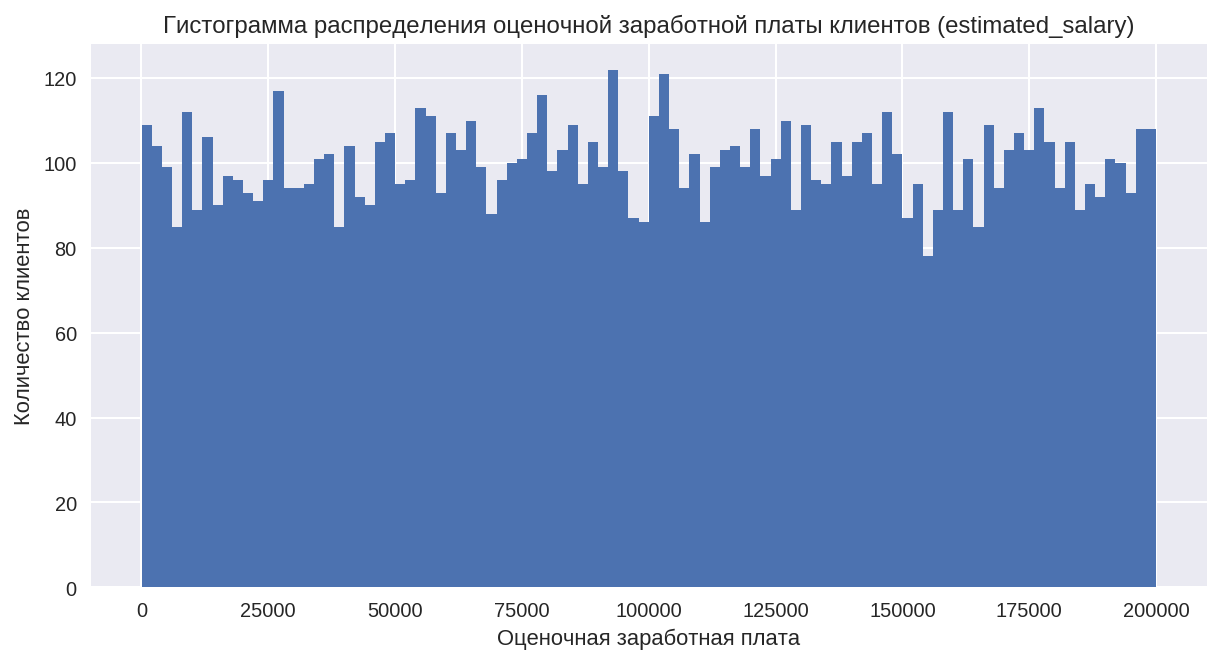

In [16]:
print_hist(df['estimated_salary'], 'Гистограмма распределения оценочной заработной платы клиентов (estimated_salary)', 'Оценочная заработная плата','Количество клиентов')

Оценочная заработная плата распределена достаточно равномерно на отрезке от 0 до 200000. Скорее всего это ошибка алгоритма оценки. Стоит сообщить коллегам о том, чтобы они проверили данный алгоритм.

#### Признак оттока (`churn`)

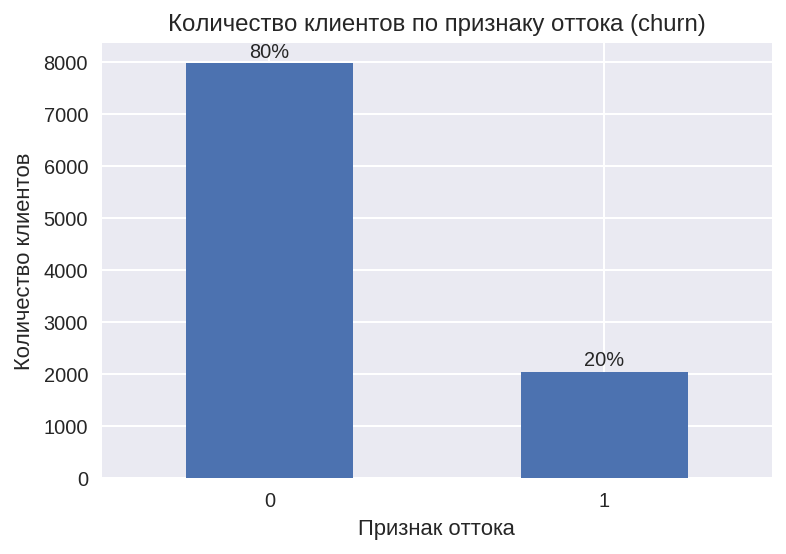

In [17]:
print_plot(df.groupby('churn')['userid'].agg('count'), 'bar', 'Количество клиентов по признаку оттока (churn)', 'Признак оттока','Количество клиентов', (6,4))

#### Баланс на счёте (`balance`)

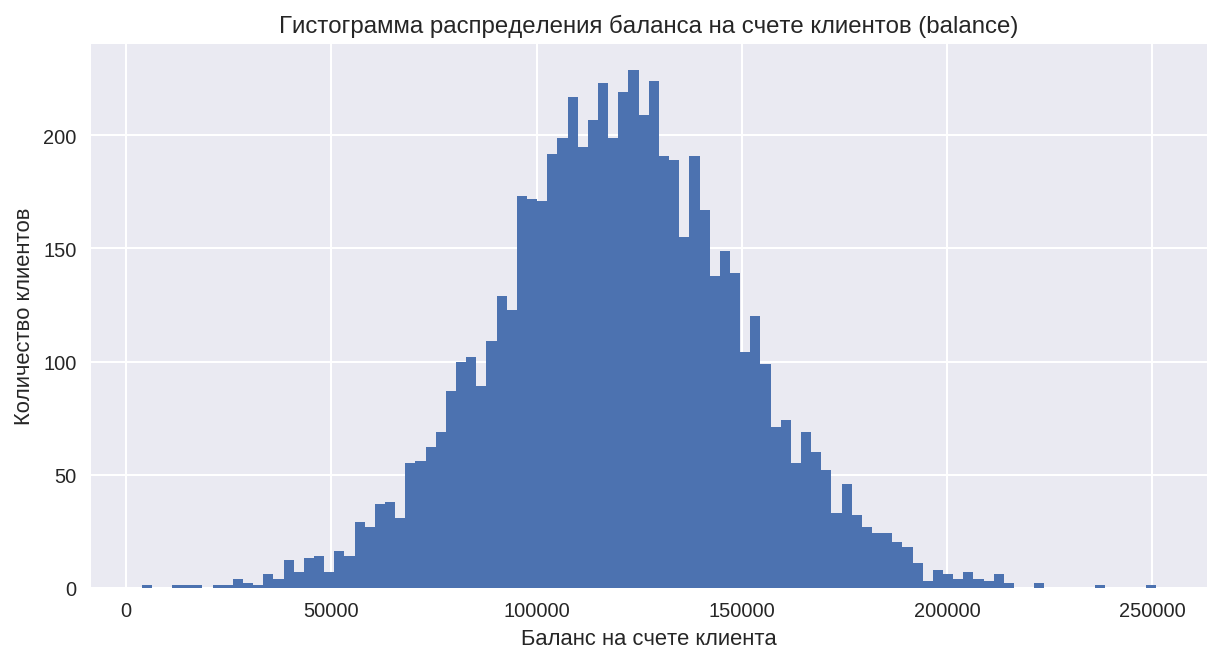

In [18]:
print_hist(df['balance'], 'Гистограмма распределения баланса на счете клиентов (balance)', 'Баланс на счете клиента','Количество клиентов')

Значения баланса на счете клиента распределены нормально, за исключением того, что в данных имеется около 3500 клиентов с пустым балансом.

Рассмотрим подробнее такие записи.

In [19]:
df[df['balance'].isna()]

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,1,1,179436.60,0
9992,15699841,726,Рыбинск,М,36,2,NaN,1,1,0,195192.40,0
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,0,0,167773.55,0
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0


В целом данные выглядят корректно. Можно предположить, что клиенты с пустым балансом - это клиенты с кредитом. 
Проверим данную гипотезу. По логике кредитная карта - это один продуктов банка. Тогда можно взять клиентов, у которых есть кредитная карта и всего один продукт и посмотреть, во всех ли таких записях есть баланс.

In [20]:
df.query("products==1 & creditcard==0")

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
18,15704243,587,Рыбинск,М,45,6,NaN,1,0,0,158684.81,0
31,15749288,533,Ярославль,М,36,7,85311.70,1,0,1,156731.91,0
36,15831184,490,Рыбинск,М,31,3,145260.23,1,0,1,114066.77,0
37,15772335,804,Рыбинск,М,33,7,76548.60,1,0,1,98453.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9971,15764113,833,Ярославль,Ж,34,3,144751.81,1,0,0,166472.81,0
9979,15735400,677,Ярославль,Ж,58,1,90022.85,1,0,1,2988.28,0
9980,15762012,741,Рыбинск,М,35,6,74371.49,1,0,0,99595.67,0
9983,15699446,613,Ярославль,М,40,4,NaN,1,0,0,151325.24,0


Видим, что в таких данные есть записи и с пустым балансом, и с положительным.

Также посмотрим, сколько клиентов с пустым балансом имеют также кредитную карту.

In [21]:
df[df['balance'].isna()].groupby('creditcard')['userid'].agg('count')

creditcard
0    1025
1    2592
Name: userid, dtype: int64

Кредитные карты имеются в достаточно большом количестве. Их доля соответствует среднему количеству по всем данным.

В примерах не видно третьего города. Проверим, у всех ли городов имеются записи с пустым балансом.

In [22]:
df[df['balance'].isna()].groupby('city')['userid'].agg('count')

city
Рыбинск      1199
Ярославль    2418
Name: userid, dtype: int64

Третьего города действительно нет среди клиентов с пустым балансом. Также можно отметить, что клиенты с пустым балансом составляют примерно половину от всех клиентов данных городов: это очень большой процент.
Можно предположить следующие объяснения данной аномалии: 
* это какая-то особенность выгрузки, в результате которой данные из колонки не были выгружены. 
* Возможно имеется продукт, который не предусматривает наличие счета в банке. И в третьем городе данный продукт отсутствует.

Посмотрим, как распределены данные с пустым балансом в разрезах других параметров.

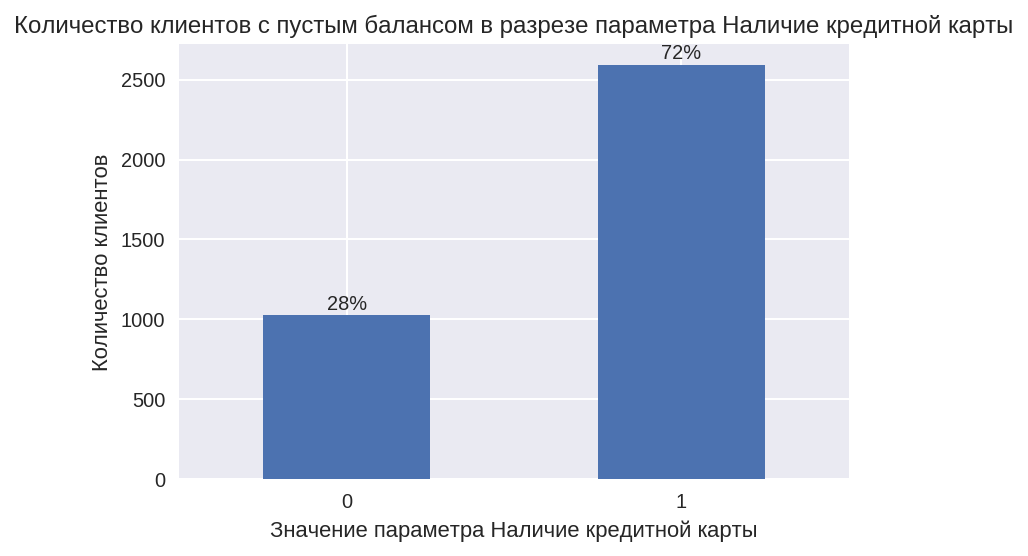

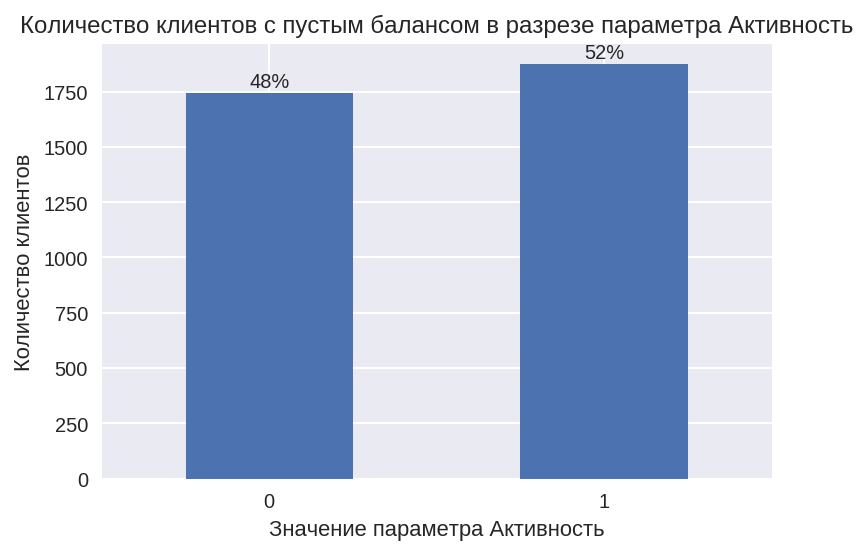

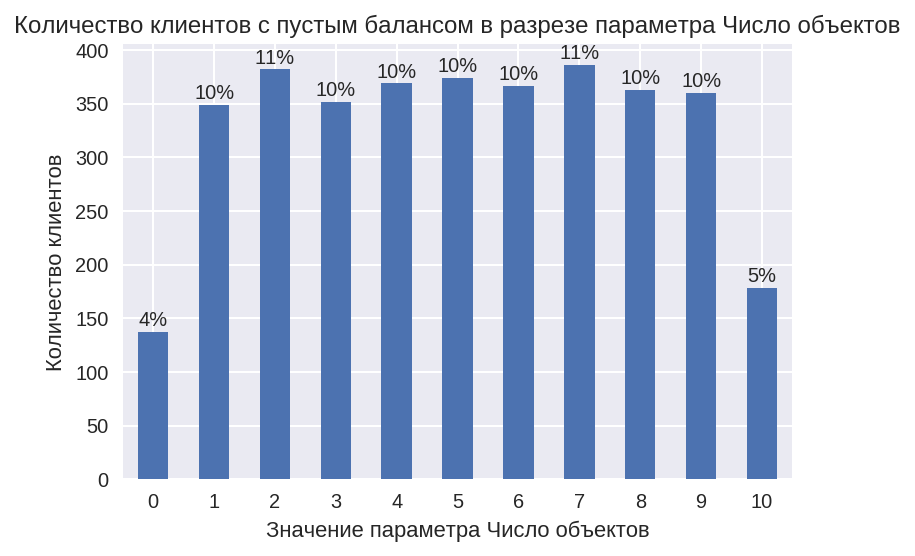

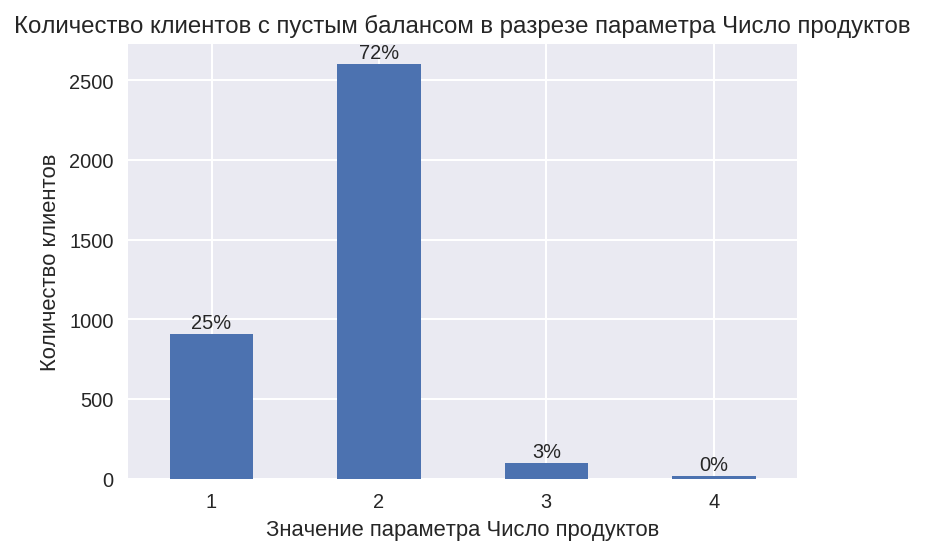

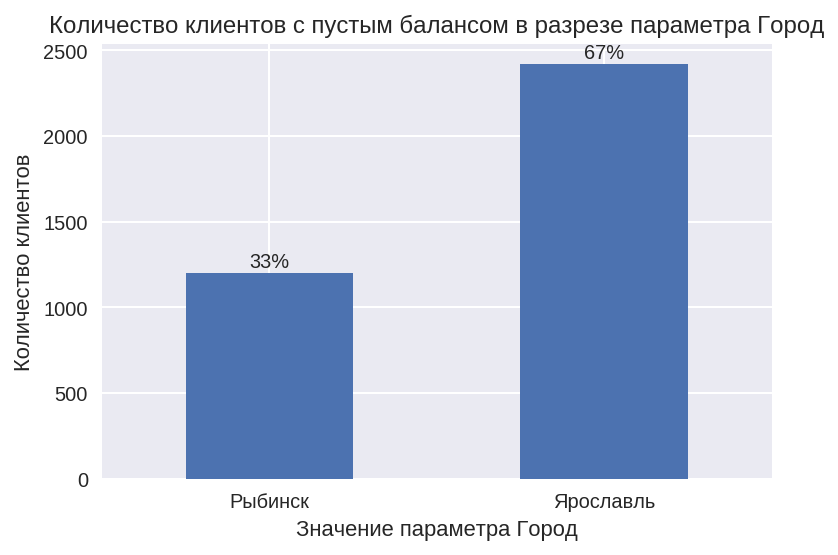

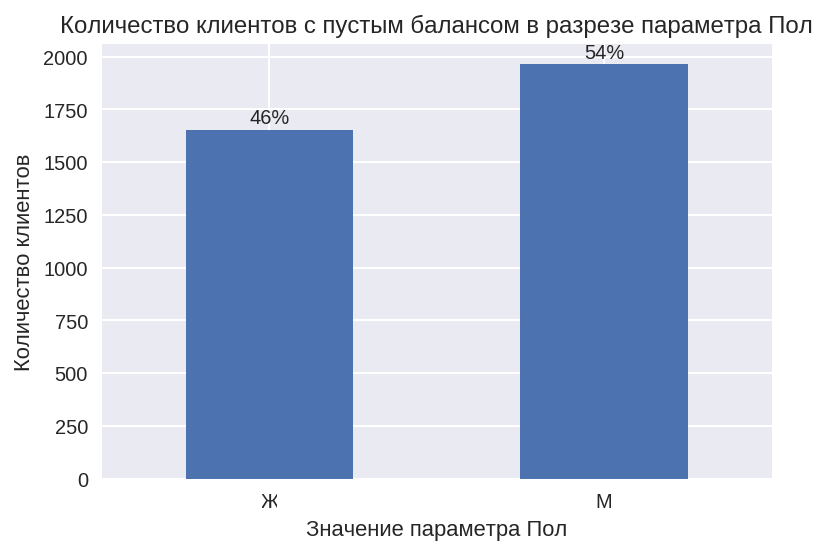

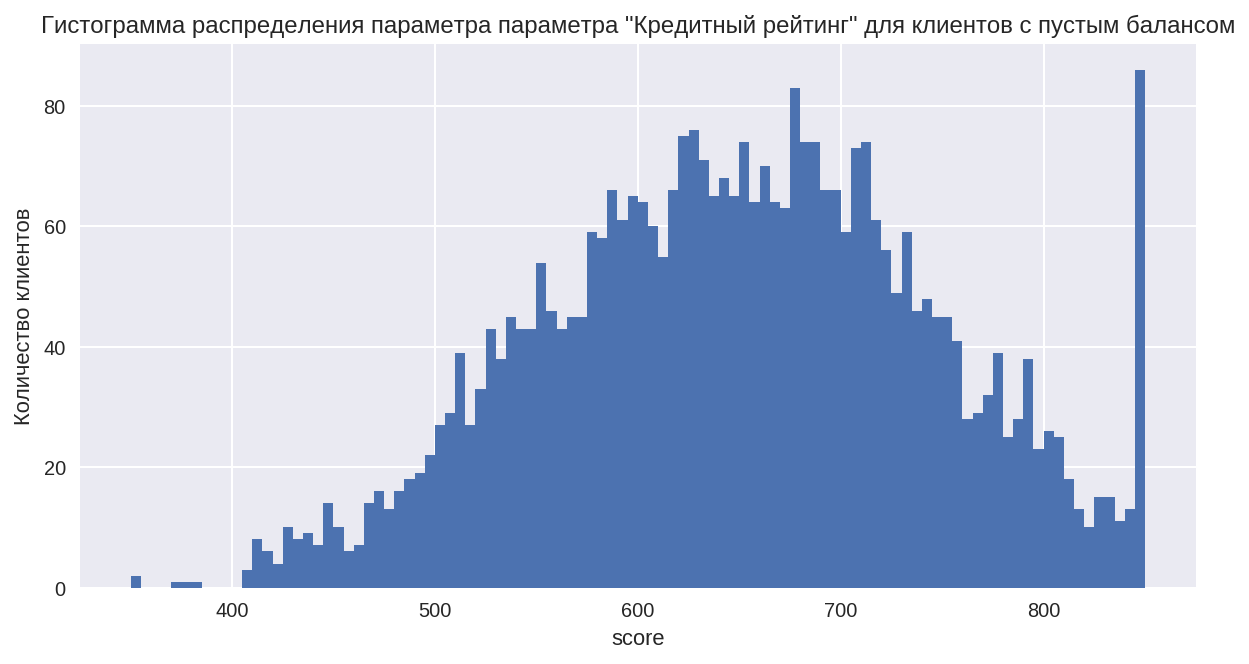

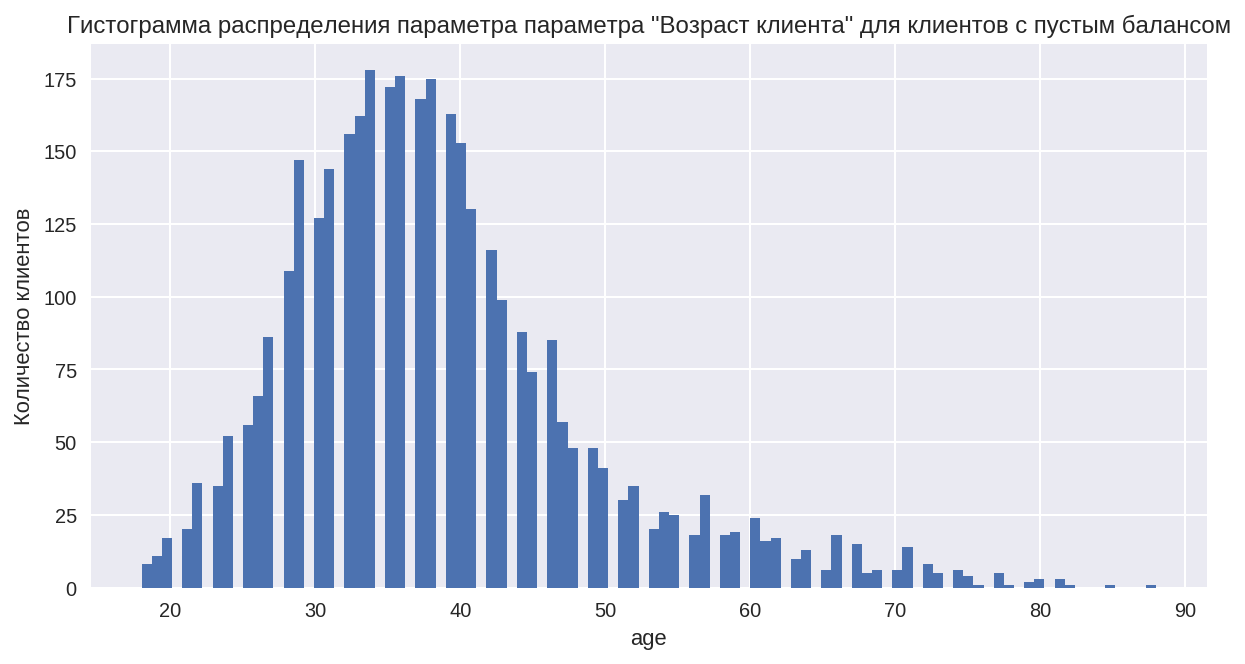

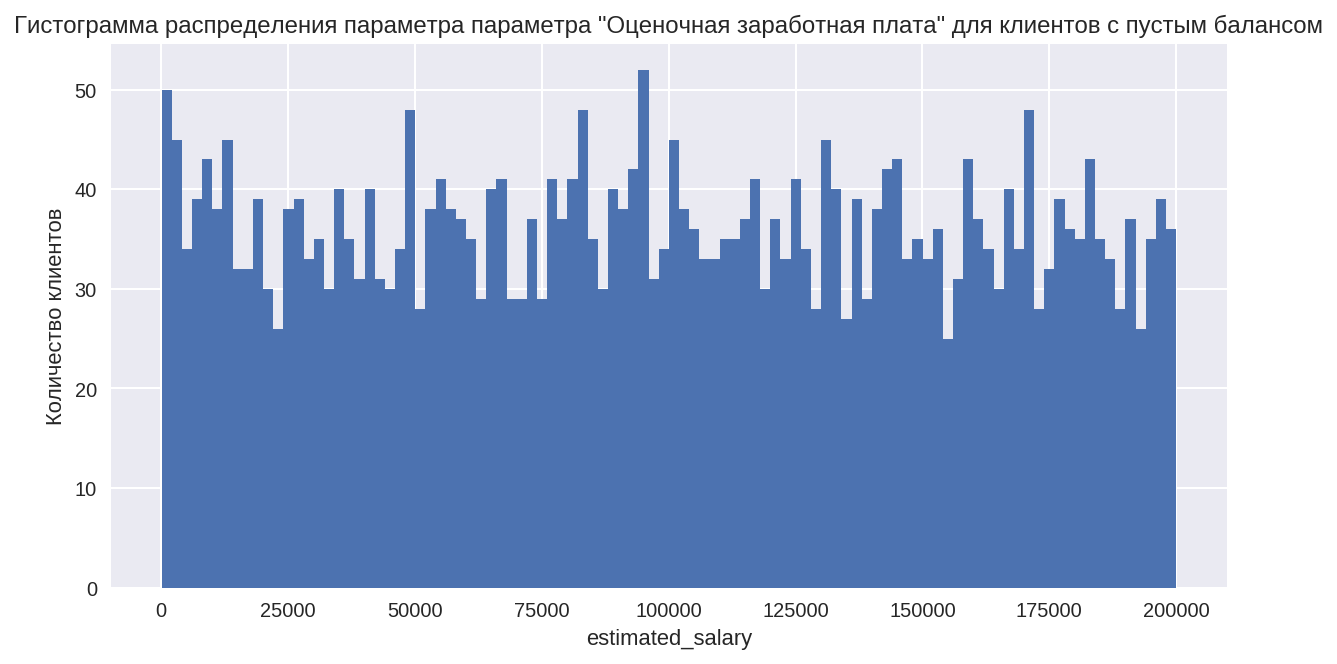

In [23]:
cat_features = {'creditcard': 'Наличие кредитной карты',
                'loyalty': 'Активность',
                'objects': 'Число объектов',
                'products': 'Число продуктов',
                'city': 'Город',
                'gender': 'Пол'}

for col, col_name in cat_features.items():
    title = 'Количество клиентов c пустым балансом в разрезе параметра '+ col_name
    xlabel = 'Значение параметра ' + col_name
    print_plot(df[df['balance'].isna()].groupby(col)['userid'].agg('count'), 'bar', title, xlabel,'Количество клиентов', (6,4))
    
num_features = {'score': 'Кредитный рейтинг',
                'age': 'Возраст клиента',
                'estimated_salary': 'Оценочная заработная плата'}

for col, col_name in num_features.items():
    title = 'Гистограмма распределения параметра параметра "'+ col_name + '" для клиентов с пустым балансом'
    xlabel = 'Значение параметра ' + col_name
    print_hist(df[df['balance'].isna()][col], title, col,'Количество клиентов', 100)

* Видно, что клиенты с пустым балансом полностью отсутсвуют в городе Ростов Великий.
* Также распределение по количеству используемых продуктов выглядит отличным от общих данных по всем клиентам: у клиентов с пустым балансом намного чаще  используют сразу два продукта
* Доля оттока среди клиентов с пустым балансом на 6% меньше, чем в общем по всем клиентам

### Корреляционный анализ

Построим матрицу корреляций и отобразим её в виде тепловой карты.

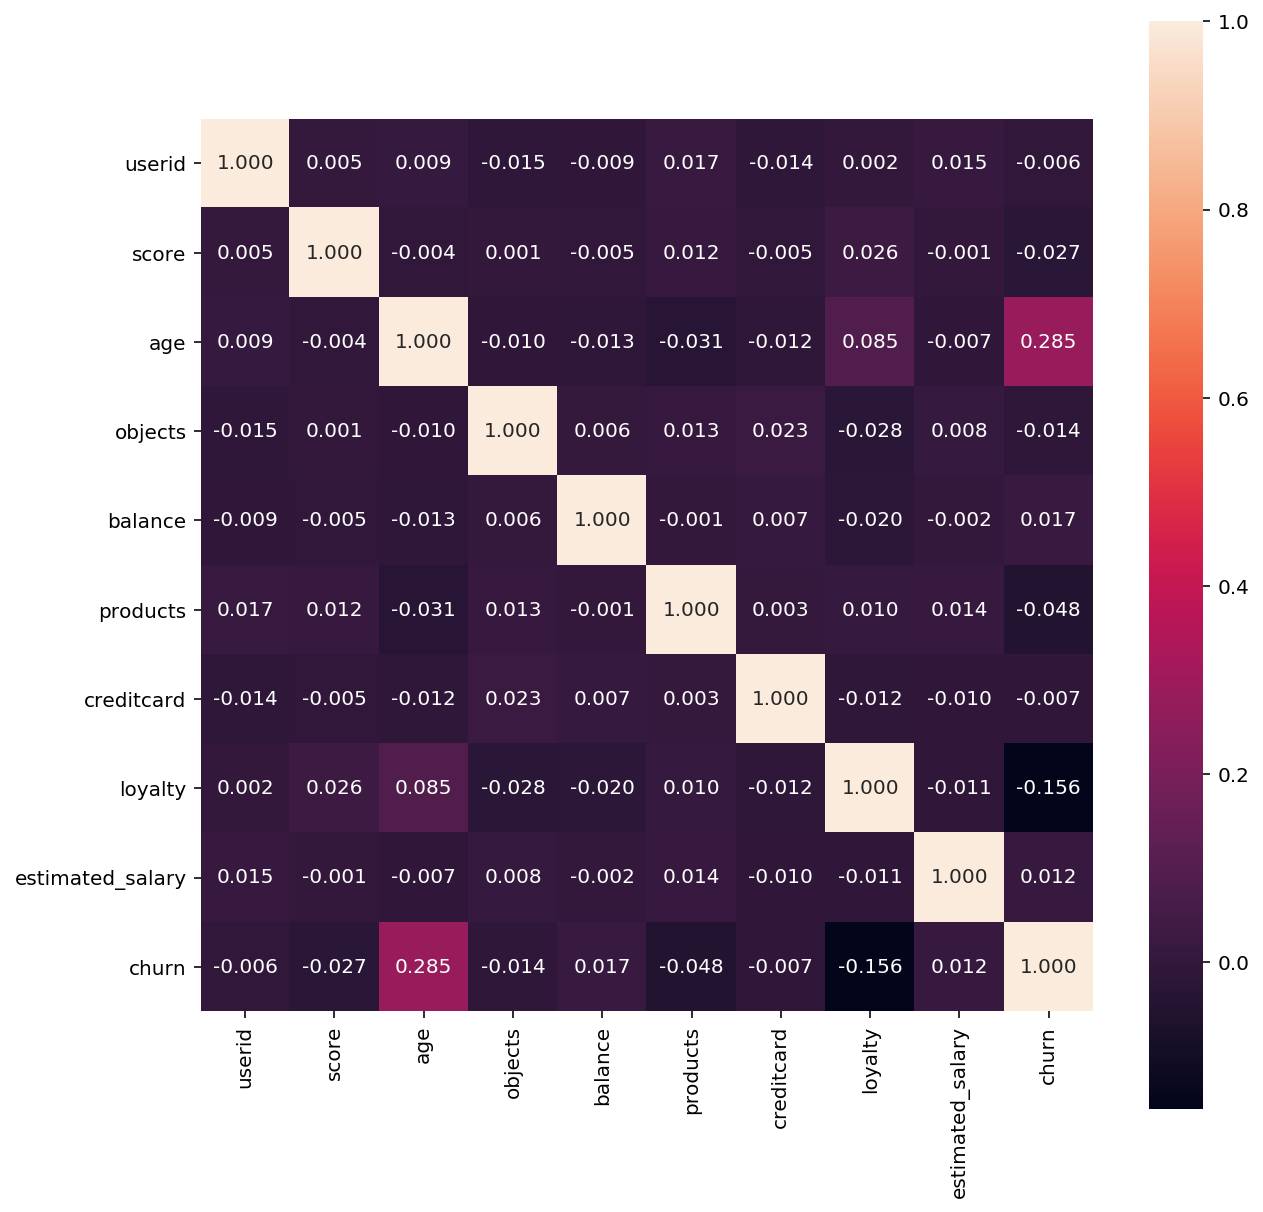

In [24]:
# формирование корреляционной матрицы
corr_m = df.corr()

# вывод матрицы на экран в виде тепловой карты (heatmap)
plt.figure(figsize = (10,10))
sns.heatmap(corr_m, square = True, annot = True, fmt=".3f")
plt.show()

По матрице видно, что в данных нет пар скоррелированных признаков.

Наибольшая корреляция наблюдается у параметров возраста клиента (`age`) и оттока (`churn`), но даже она очень низкая (0.285).

На втором месте по значению коэффициента корреляции (0.156) - параметры активности клиента (`loyalty`) и оттока (`churn`).

### Выводы по шагу 2

1. В данных имеется большое число клиентов с максимальным кредитным рейтингом (`score`), равным 850.
1. При изучении пропусков баланса (`balance`) обнаружены следующие отличия от общих данных:
    * клиенты с пустым балансом отсутствуют в городе Ростов Великий;
    * клиенты с пустым балансом намного чаще используют сразу два продукта;
    * доля оттока клиентов с пустым балансом на 6% ниже, чем в среднем по всем клиентам.
    
    Принято решение никак не обрабатывать данные пропуски.
1. Подавляющее большинство клиентов банка пользуются всего одним или двумя продуктами.
1. Распределение клиентов по полу практически равное: доля мужчин (55%) чуть больше, чем женщин.
1. 20% клиентов из имеющихся ушли в отток.
1. Доля активных клиентов составляет примерно 50%.
1. 70% клиентов банка имеют кредитные карты.
1. Оценочная заработная плата клиента (`estimated_salary`) распределена равномерно. Это похоже на ошибку алгоритма расчета данного показателя. Стоит сообщить коллегам, занимающимся расчетом данного показателя, чтобы проверили алгоритм.
1. Корреляционный анализ показал, что в данных нет параметров, явно коррелирующих друг с другом.


## 3. Анализ оттока и построение портрета клиентов<a class="anchor" id="h1_3"></a>
Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [25]:
df.groupby('churn').agg('mean')

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


In [29]:
df.groupby('churn').agg('mean').T.style.background_gradient("Reds", axis=1)

churn,0,1
userid,1.57339e+07,1.57328e+07
score,651.853,645.351
age,37.4084,44.838
objects,5.03328,4.93274
balance,119536,120747
products,1.54427,1.47521
creditcard,0.707146,0.699067
loyalty,0.554565,0.360825
estimated_salary,99738.4,101466


Средние значения в двух группах различаются значительно по двум признакам: возраст (`age`) и уровень активности (`loyalty`).

Рассмотрим подробнее категориальные признаки. Рассчитаем для таких признаков долю оттока по каждой категории.

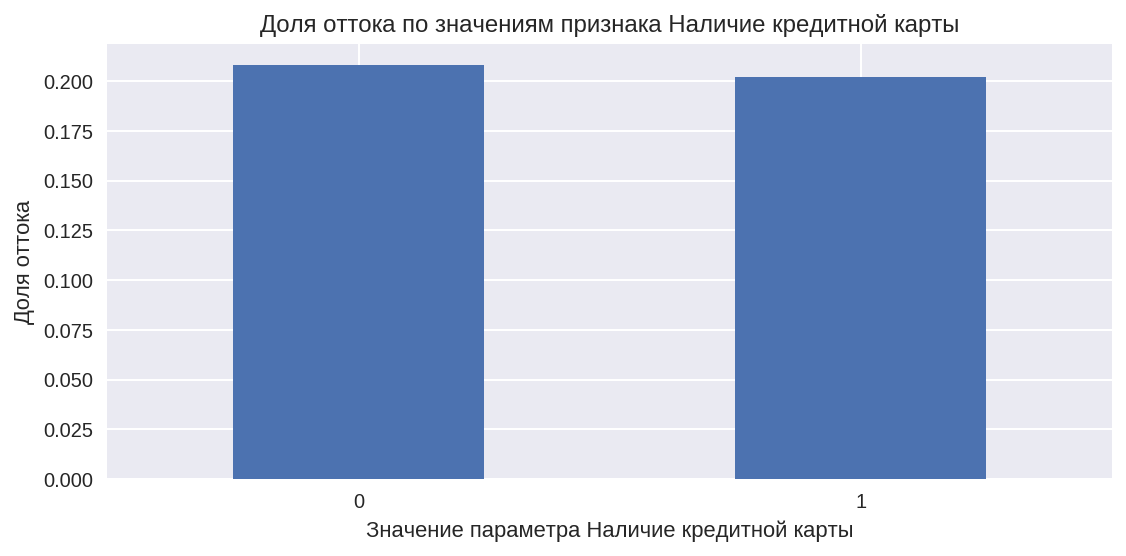

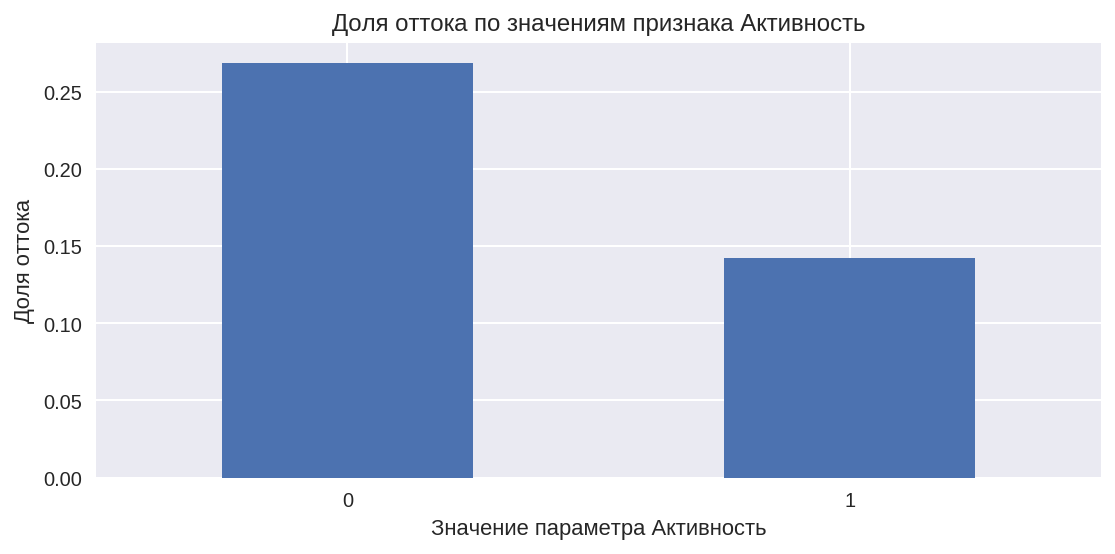

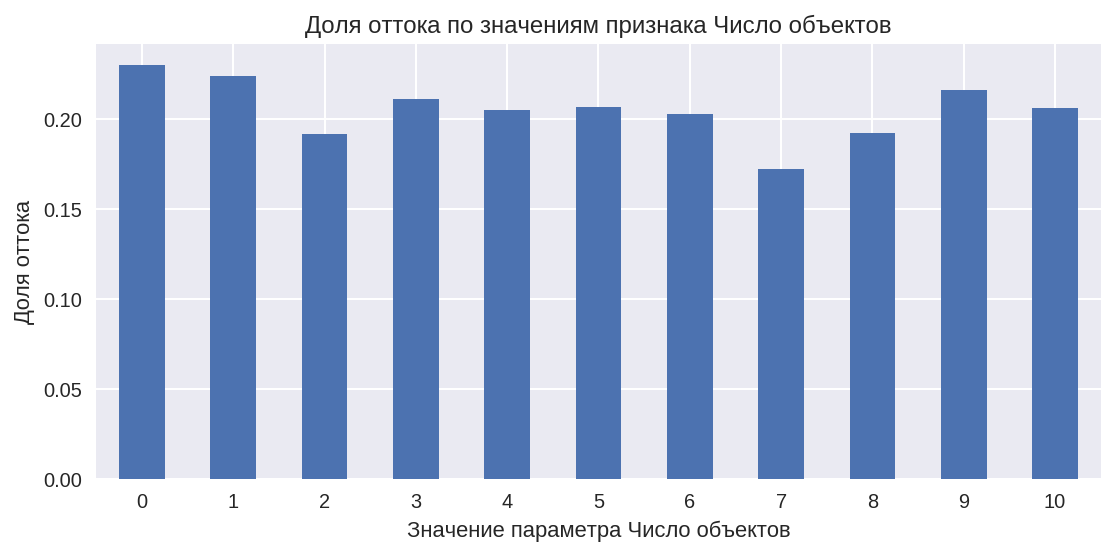

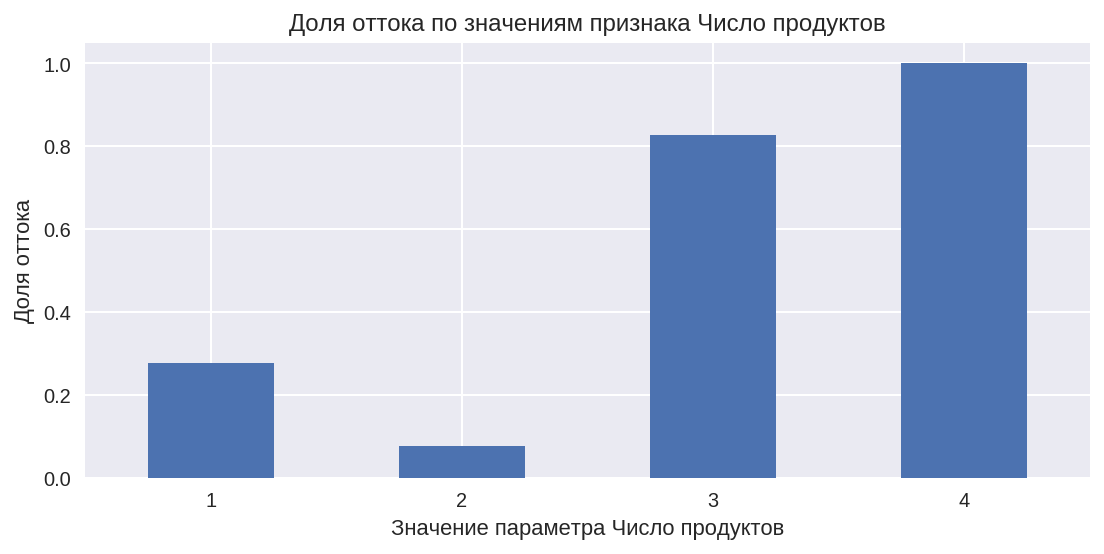

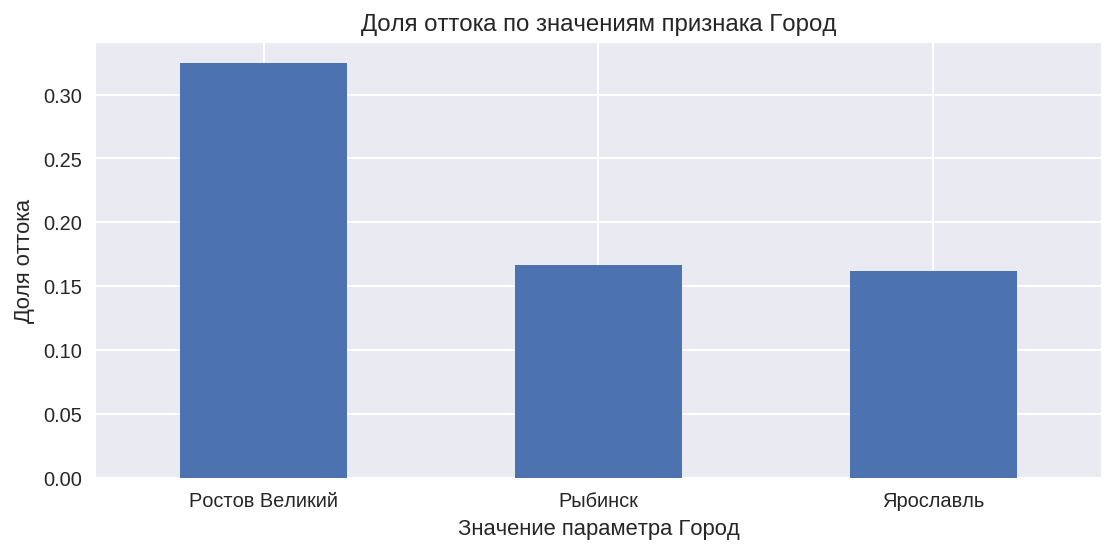

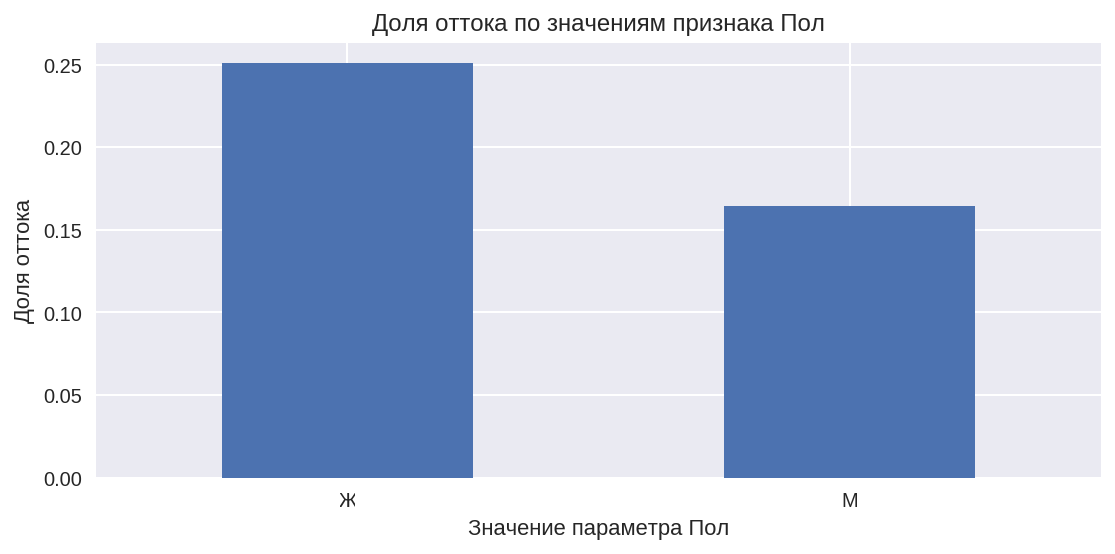

In [26]:
for col, col_name in cat_features.items():
    title = 'Доля оттока по значениям признака '+ col_name
    xlabel = 'Значение параметра ' + col_name
    print_plot(df.groupby(col)['churn'].agg('mean'), 'bar', title, xlabel,'Доля оттока', (9,4), False)

Полученные диаграммы наглядно показывают, что доля оттока:
* доли клиентов с кредитной картой одинаковы среди обеих групп (среди ушедших и оставшихся)
* доли активных клиентов заметно различаются: среди оставшихся 55% клиентов активны, среди ушедших - только 35%.
* не меняется значительно в зависимости от числа объектов в собственности
* очень сильно меняется в зависимости от количества продуктов. При 4 продуктах доля оттока составляет 100%, при 3 продуктах - более 80%. Наименьшая доля оттока при 2 продуктах - всего 3%.
* доля оттока среди мужчин на 10% меньше, чем среди женщин
* в городе Ростов Великий доля оттока в 2 раза больше, чем в Ярославле и Рыбинске.

Далее построим гистограммы плотностей распределения для численных признаков.

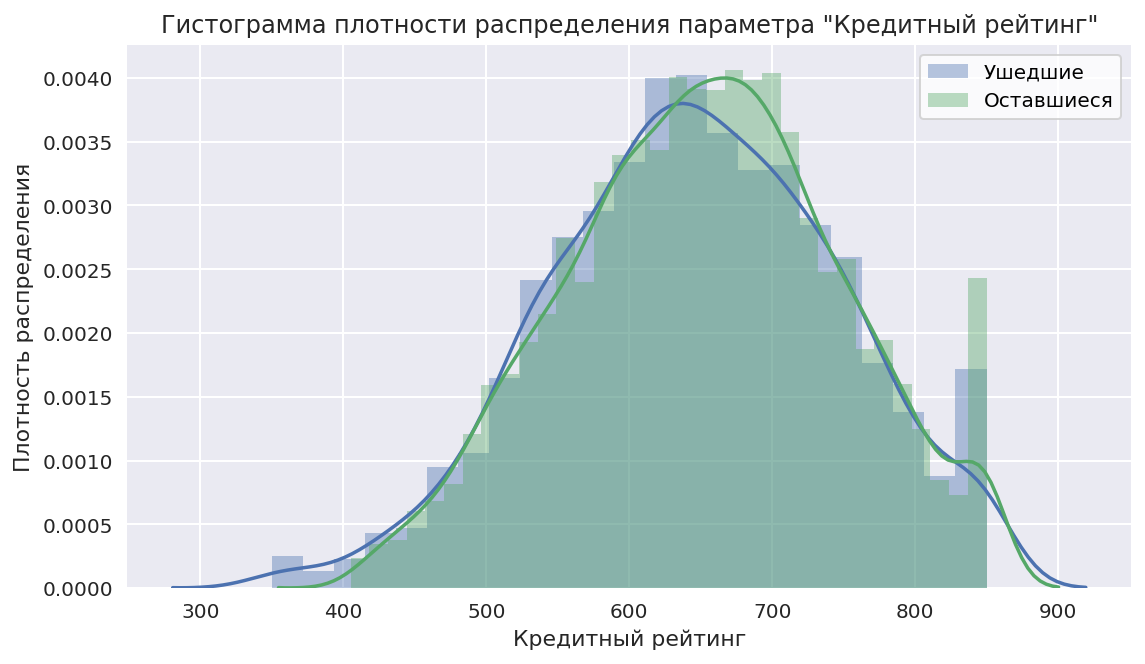

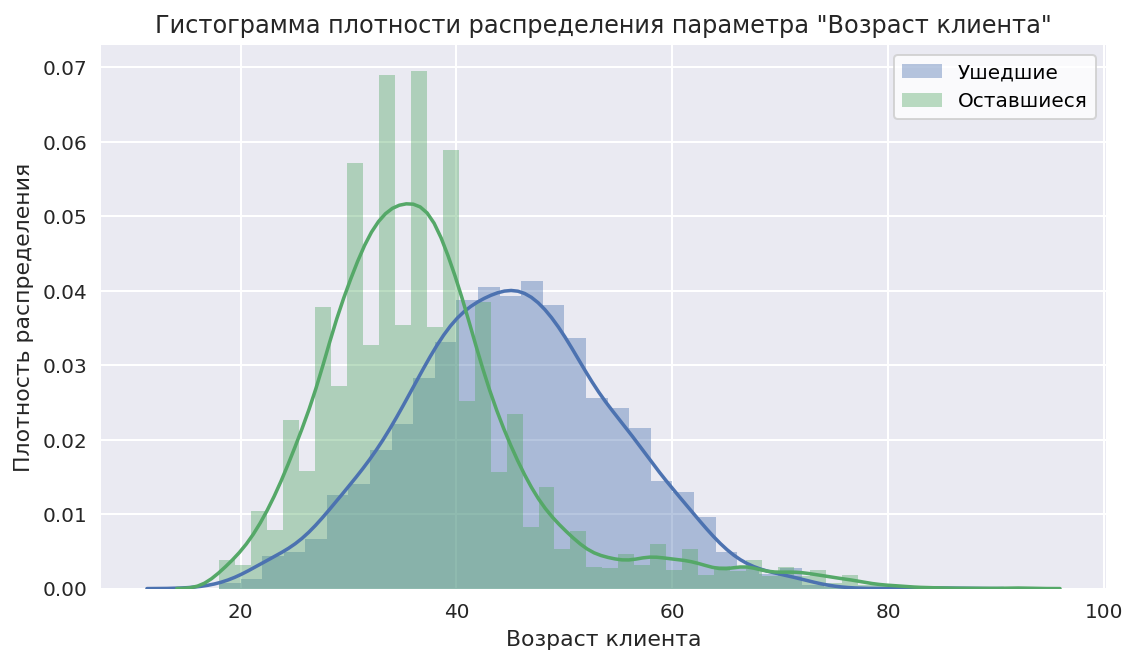

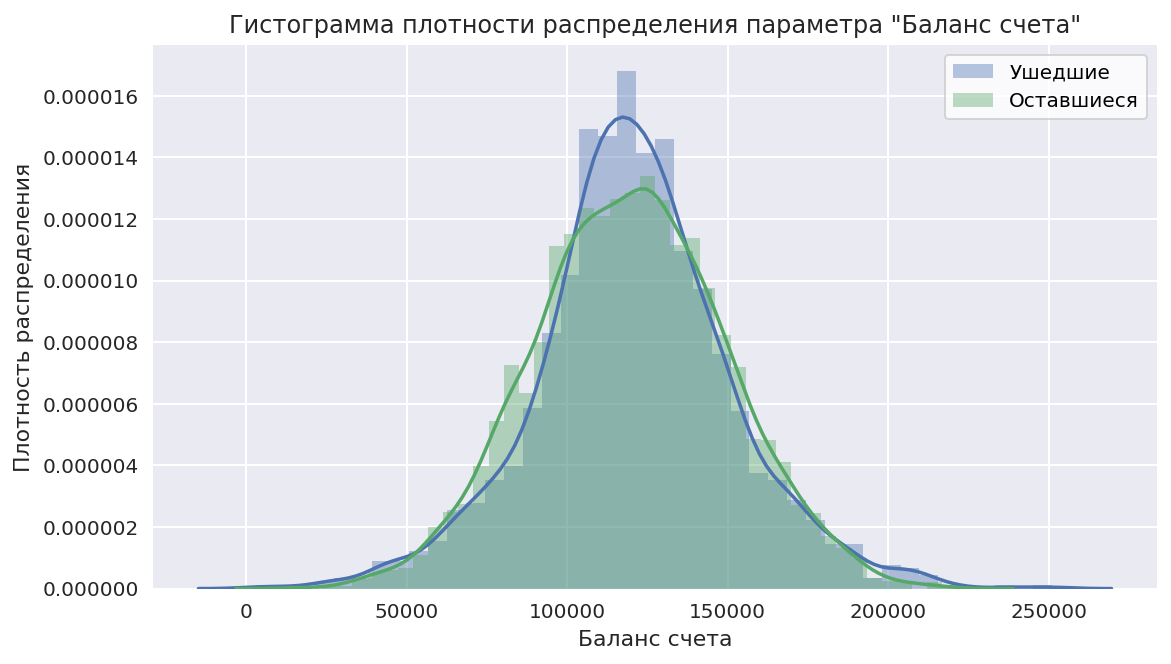

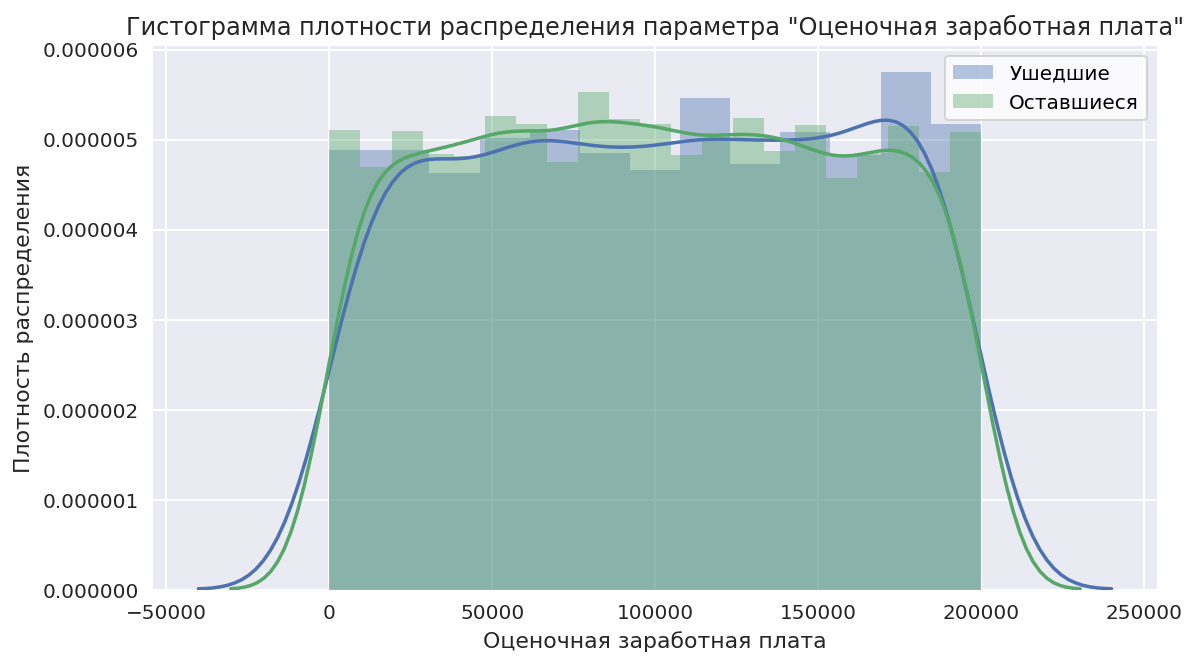

In [30]:
num_features = ['score','age','balance','estimated_salary']
num_features = {'score': 'Кредитный рейтинг',
                'age': 'Возраст клиента',
                'balance':'Баланс счета',
                'estimated_salary': 'Оценочная заработная плата'}

# Построение гистограмм

for col, col_name in num_features.items():
    plt.figure(figsize=(9,5))
    with plt.style.context('seaborn'):
        sns.distplot(df[df['churn']==1][col].dropna())
        sns.distplot(df[df['churn']==0][col].dropna())
    labels= [ "Ушедшие","Оставшиеся"]
    plt.grid(True)
    plt.title('Гистограмма плотности распределения параметра "{}"'.format(col_name))
    plt.legend(labels)
    plt.xlabel(col_name)
    plt.ylabel('Плотность распределения')
    plt.show()

По гистограммам можно сделать следующие выводы:
    * Кредитный рейтинг среди оставшихся и ушедших клиентов практически не отличается. Рейтинг оставшихся клиентов чуть больше.
    * Средний возраст клиентов, более склонных к оттоку (37 лет), заметно меньше возраста клиентов, менее склонных к оттоку (45 лет).
    * Средний баланс клиентов двух групп практически не отличается.
    * Оценочная зарплата клиентов двух групп не отличается.

### Выводы по шагу 3
Проведенный анализ позволил выделить основные признаки, влияющие на отток клиентов из банка:
* активность клиента: среди оставшихся 55% клиентов активны, среди ушедших - только 35%
* город: в городе Ростов Великий доля оттока в 2 раза больше (35%), чем в Ярославле и Рыбинске (17%).
* возраст: средний возраст ушедших в отток клиентов - 37 лет, оставшихся - 45 лет.
* число продуктов: при 2 продуктах доля оттока около 10%, при более двух продуктах - 80%. Также необходимо отметить, что 3 и 4 продукта имеют достаточно небольшое количество клиентов. Возможно какие-то два продукта являются новыми и до конца не отработанными. В результате клиенты оказываются очень недовольны их использованием и уходят от банка.
* пол: доля оттока среди мужчин на заметно меньше (16%), чем среди женщин (25%).

Признаки, по которым не выявлено влияния на отток:
* оценочная заработная плата
* баланс на счете
* кредитный рейтинг
* число объектов в собственности
* наличие кредитной карты

Таким образом можно выделить портрет клиентов, которые наименее склонны уходить из банка:
* активно используют услуги банка, при этом пользуются не более, чем двумя продуктами;
* средний возраст около 45 лет;
* мужского пола;
* из города Ярославля или Рыбинска.

## 4. Формулировка и проверка гипотез<a class="anchor" id="h1_4"></a>
На данном шаге обязательно необходимо проверить следующую гипотезу: есть ли различие дохода между теми клиентами, которые ушли и теми, которые остались.

#### Наличие различия дохода между ушедшими и оставшимися клиентами
Сначала сформулируем нулевую и альтернативную гипотезы.

**Н0**: Средние доходы ушедших и оставшихся клиентов равны.

**Н1**: Средние доходы ушедших и оставшихся клиентов отличаются.

Рассчитаем средние значения и дисперсии для каждой группы:

In [31]:
print('Cредний доход ушедших клиентов: {:.1f}'.format(df.query('churn == 1')['estimated_salary'].mean()))
print('Дисперсия доходов ушедших клиентов: {:.1f}'.format(df.query('churn == 1')['estimated_salary'].var()))
print('Cредний доход оставшихся клиентов: {:.1f}'.format(df.query('churn == 0')['estimated_salary'].mean()))
print('Дисперсия доходов оставшихся клиентов: {:.1f}'.format(df.query('churn == 0')['estimated_salary'].var()))

Cредний доход ушедших клиентов: 101465.7
Дисперсия доходов ушедших клиентов: 3353848166.8
Cредний доход оставшихся клиентов: 99738.4
Дисперсия доходов оставшихся клиентов: 3295401414.9


Средние доходы и дисперсии получились схожими. Но такие результаты могли получиться случайно. Осуществим проверку сформулированной гипотезы.

Сначала проверим выборки на гомогенность дисперсий сравниваемых выборок. Для этого будем использовать тест Левина. Если p-уровень значимости будет меньше критического для нас уровня статистической значимости (т.е. вероятность равенства дисперсий достаточно низкая), то при проверке нулевой гипотезы необходимо использовать t-критерий Уэлча (использовать параметр `equal_var = False`), иначе будем использовать t-критерий Стьюдента (`equal_var = True`).

In [32]:
stat_ttest(
    df.query('churn == 1')['estimated_salary'],
    df.query('churn == 0')['estimated_salary'])

p-значение для теста Левина:  0.33529517185148194
Не получилось отвергнуть гипотезу о равенстве дисперсий сравниваемых выборок.
p-значение для t-теста:  0.228924613051458
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что с вероятностью почти 23% текущее различие между средними доходами ушедших и оставшихся клиентов можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними доходами данных групп.

#### Средний кредитный рейтинг у ушедших и оставшихся клиентов одинаков
**Н0**: Средние кредитные рейтинги ушедших и оставшихся клиентов равны.

**Н1**: Средние кредитные рейтинги ушедших и оставшихся клиентов отличается.

In [33]:
print('Cредний кредитный рейтинг ушедших клиентов: {:.1f}'.format(df.query('churn == 1')['score'].mean()))
print('Дисперсия кредитного рейтинга ушедших клиентов: {:.1f}'.format(df.query('churn == 1')['score'].var()))
print('Cредний кредитный рейтинг оставшихся клиентов: {:.1f}'.format(df.query('churn == 0')['score'].mean()))
print('Дисперсия кредитного рейтинга оставшихся клиентов: {:.1f}'.format(df.query('churn == 0')['score'].var()))

Cредний кредитный рейтинг ушедших клиентов: 645.4
Дисперсия кредитного рейтинга ушедших клиентов: 10064.4
Cредний кредитный рейтинг оставшихся клиентов: 651.9
Дисперсия кредитного рейтинга оставшихся клиентов: 9149.7


In [34]:
stat_ttest(
    df.query('churn == 1')['score'],
    df.query('churn == 0')['score'])

p-значение для теста Левина:  0.019034723520343893
Отвергаем гипотезу о равенстве дисперсий сравниваемых выборок.
p-значение для t-теста:  0.006738213892192373
Отвергаем нулевую гипотезу


Таким образом, текущее различие между средними кредитными рейтингами ушедших и оставшихся клиентов нельзя получить случайно.

#### Средний баланс у ушедших и оставшихся клиентов одинаков
**Н0**: Средние кредитные рейтинги ушедших и оставшихся клиентов (с непустым балансом) равны.

**Н1**: Средние кредитные рейтинги ушедших и оставшихся клиентов (с непустым балансом) отличается.

In [35]:
print('Cредний баланс ушедших клиентов: {:.1f}'.format(df.query('churn == 1 & balance==balance')['balance'].mean()))
print('Дисперсия баланса ушедших клиентов: {:.1f}'.format(df.query('churn == 1 & balance==balance')['balance'].var()))
print('Cредний баланс оставшихся клиентов: {:.1f}'.format(df.query('churn == 0 & balance==balance')['balance'].mean()))
print('Дисперсия баланса оставшихся клиентов: {:.1f}'.format(df.query('churn == 0 & balance==balance')['balance'].var()))

Cредний баланс ушедших клиентов: 120747.0
Дисперсия баланса ушедших клиентов: 933619807.2
Cредний баланс оставшихся клиентов: 119535.9
Дисперсия баланса оставшихся клиентов: 896698675.3


In [36]:
stat_ttest(
    df.query('churn == 1 & balance==balance')['balance'],
    df.query('churn == 0 & balance==balance')['balance'])

p-значение для теста Левина:  0.09064612090269891
Не получилось отвергнуть гипотезу о равенстве дисперсий сравниваемых выборок.
p-значение для t-теста:  0.17379960354870824
Не получилось отвергнуть нулевую гипотезу


С вероятностью 17% текущее различие между средними балансами ушедших и оставшихся клиентов (с непустым балансом) можно получить случайно.

###  Выводы по шагу 4
В результате статистической проверки сформулированных гипотез выяснено следующее:

* Средние доходы между ушедшими и оставшимися клиентами не различаются.
* Средний кредитный рейтинг у ушедших и оставшихся клиентов различен.
* Средний баланс у ушедших и оставшихся клиентов (с непустым балансом) не различается.

## 5. Кластеризация клиентов<a class="anchor" id="h1_5"></a>
Проведем кластеризацию клиентов.

Для начала стандартизируем данные и построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

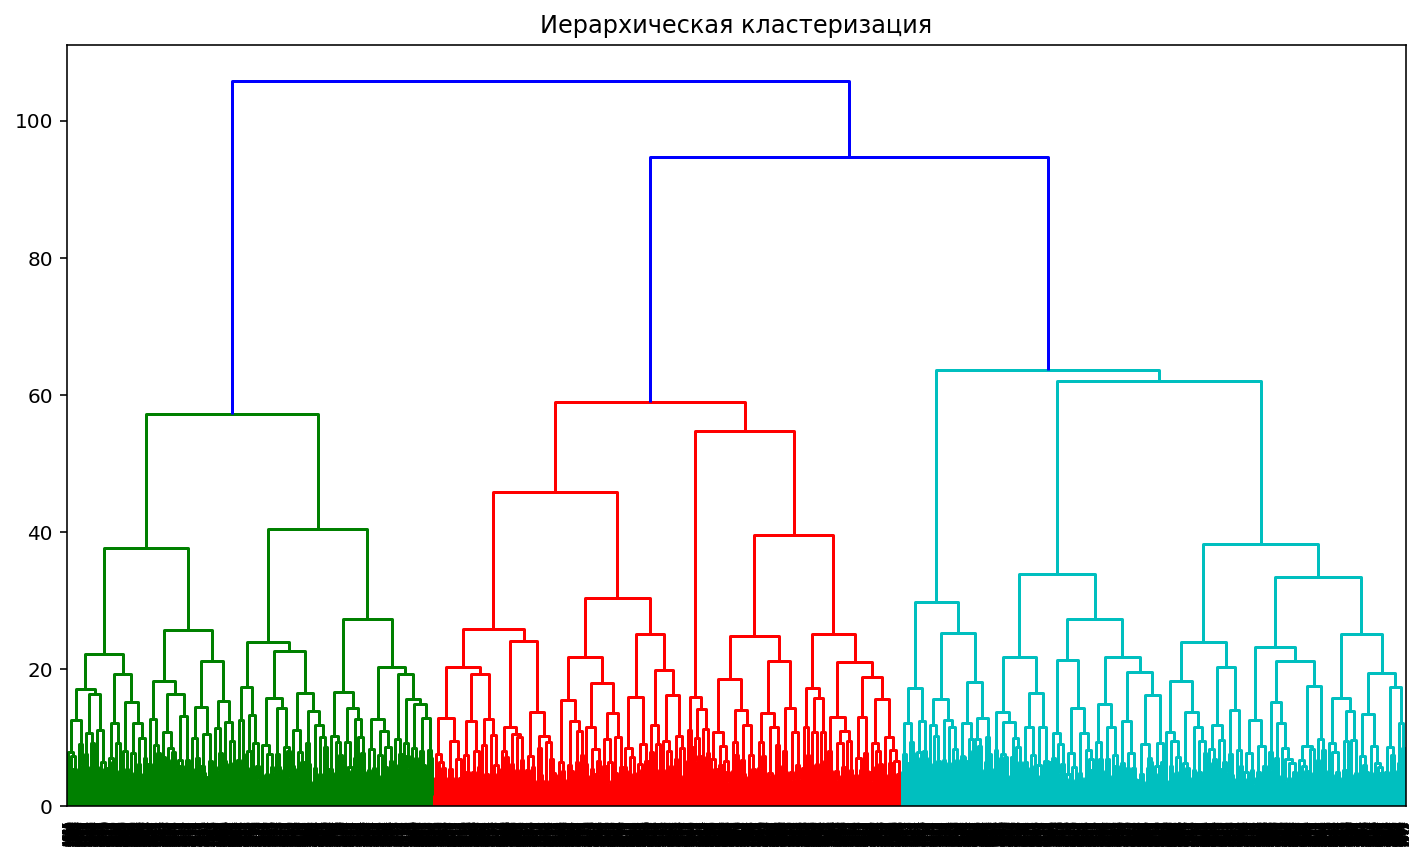

In [37]:
train_data = df.copy()
train_data = train_data.drop('userid', axis = 1)

# Удаление пустых значений из датафрейма
train_data.dropna(inplace = True)

le = preprocessing.LabelEncoder()
# Преобразование категориальных значений в числовые
for column_name in train_data.columns:
    if train_data[column_name].dtype == object:
        train_data[column_name] = le.fit_transform(train_data[column_name])
    else:
        pass
    
# создание объекта класса StandardScaler и применение его к датафрейму, отбросив столбец с оттоком
sc = StandardScaler()

# обучение scaler и одновременно трансформация матрицы для обучающей выборки
x_sc = sc.fit_transform(train_data.drop('churn', axis = 1))

# сохранение в переменной linked таблицы «связок» между объектами. 
linked = linkage(x_sc, method = 'ward')

# создание и визуализации дендрограммы
plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

На основании полученного графика можно предположить, что в данных можно выделить 3 кластера.

Теперь обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=3.

In [38]:
# задание модели k_means с числом кластеров 3
km = KMeans(n_clusters = 3, random_state=0)

# прогнозирование кластеров для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохранение метки кластера в поле датасета
train_data['cluster_client'] = labels

# вывод статистики по средним значениям признаков по кластеру
train_data.groupby(['cluster_client']).mean()

,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
cluster_client,,,,,,,,,,,
0,653.458278,1.018985,0.568653,39.541722,4.931567,119377.924896,1.382781,1.0,1.000000,99288.559210,0.161148
1,653.364063,1.039062,0.541667,39.524479,4.864583,119519.124656,1.383333,0.0,0.527604,101101.214437,0.242188
2,646.803913,0.985896,0.530482,38.557780,5.129663,120560.133599,1.391720,1.0,0.000000,101854.388348,0.321656


На основе средних значений можно выделить кластер с наименьшей долей оттока - №1. Также можно сказать, что алгорим за основной признак данного кластера выбрал активность (`loyalty`) и наличие кредитной карты (`creditcard`).

Построим для наглядности диаграмму, показывающую по каждому кластеру долю оттока клиентов.

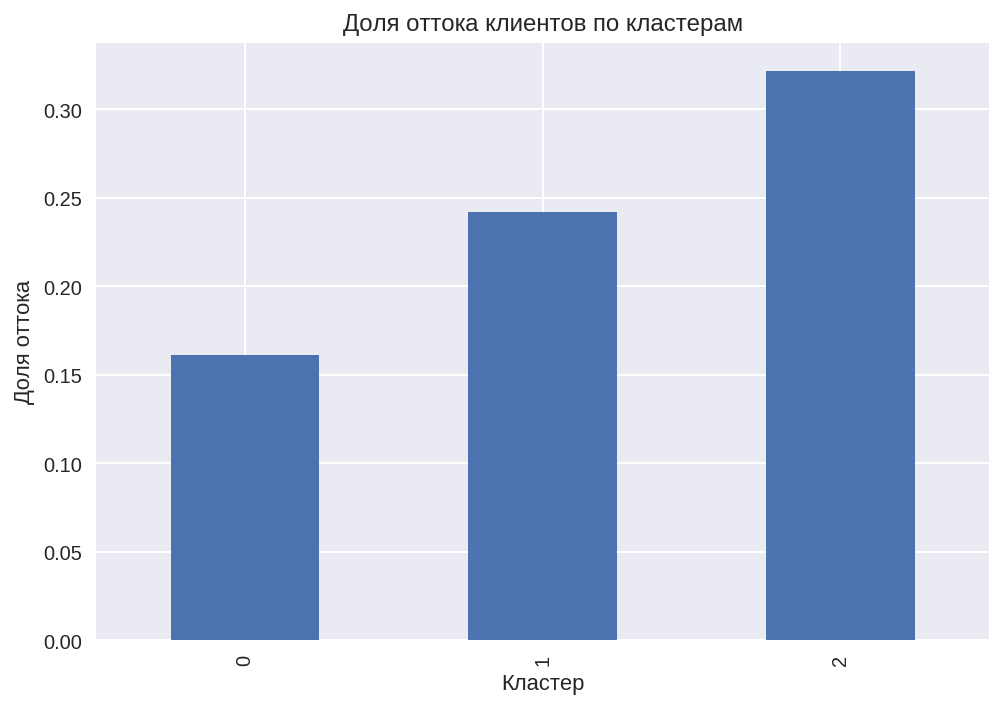

In [39]:
with plt.style.context('seaborn'):
    train_data.groupby('cluster_client')['churn'].agg('mean').plot(kind='bar')
    plt.title('Доля оттока клиентов по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Доля оттока')    
    plt.show()

Чтобы детальнее сравнить кластеры, построим по каждому признаку кластеров гистограммы распределения и диаграммы.

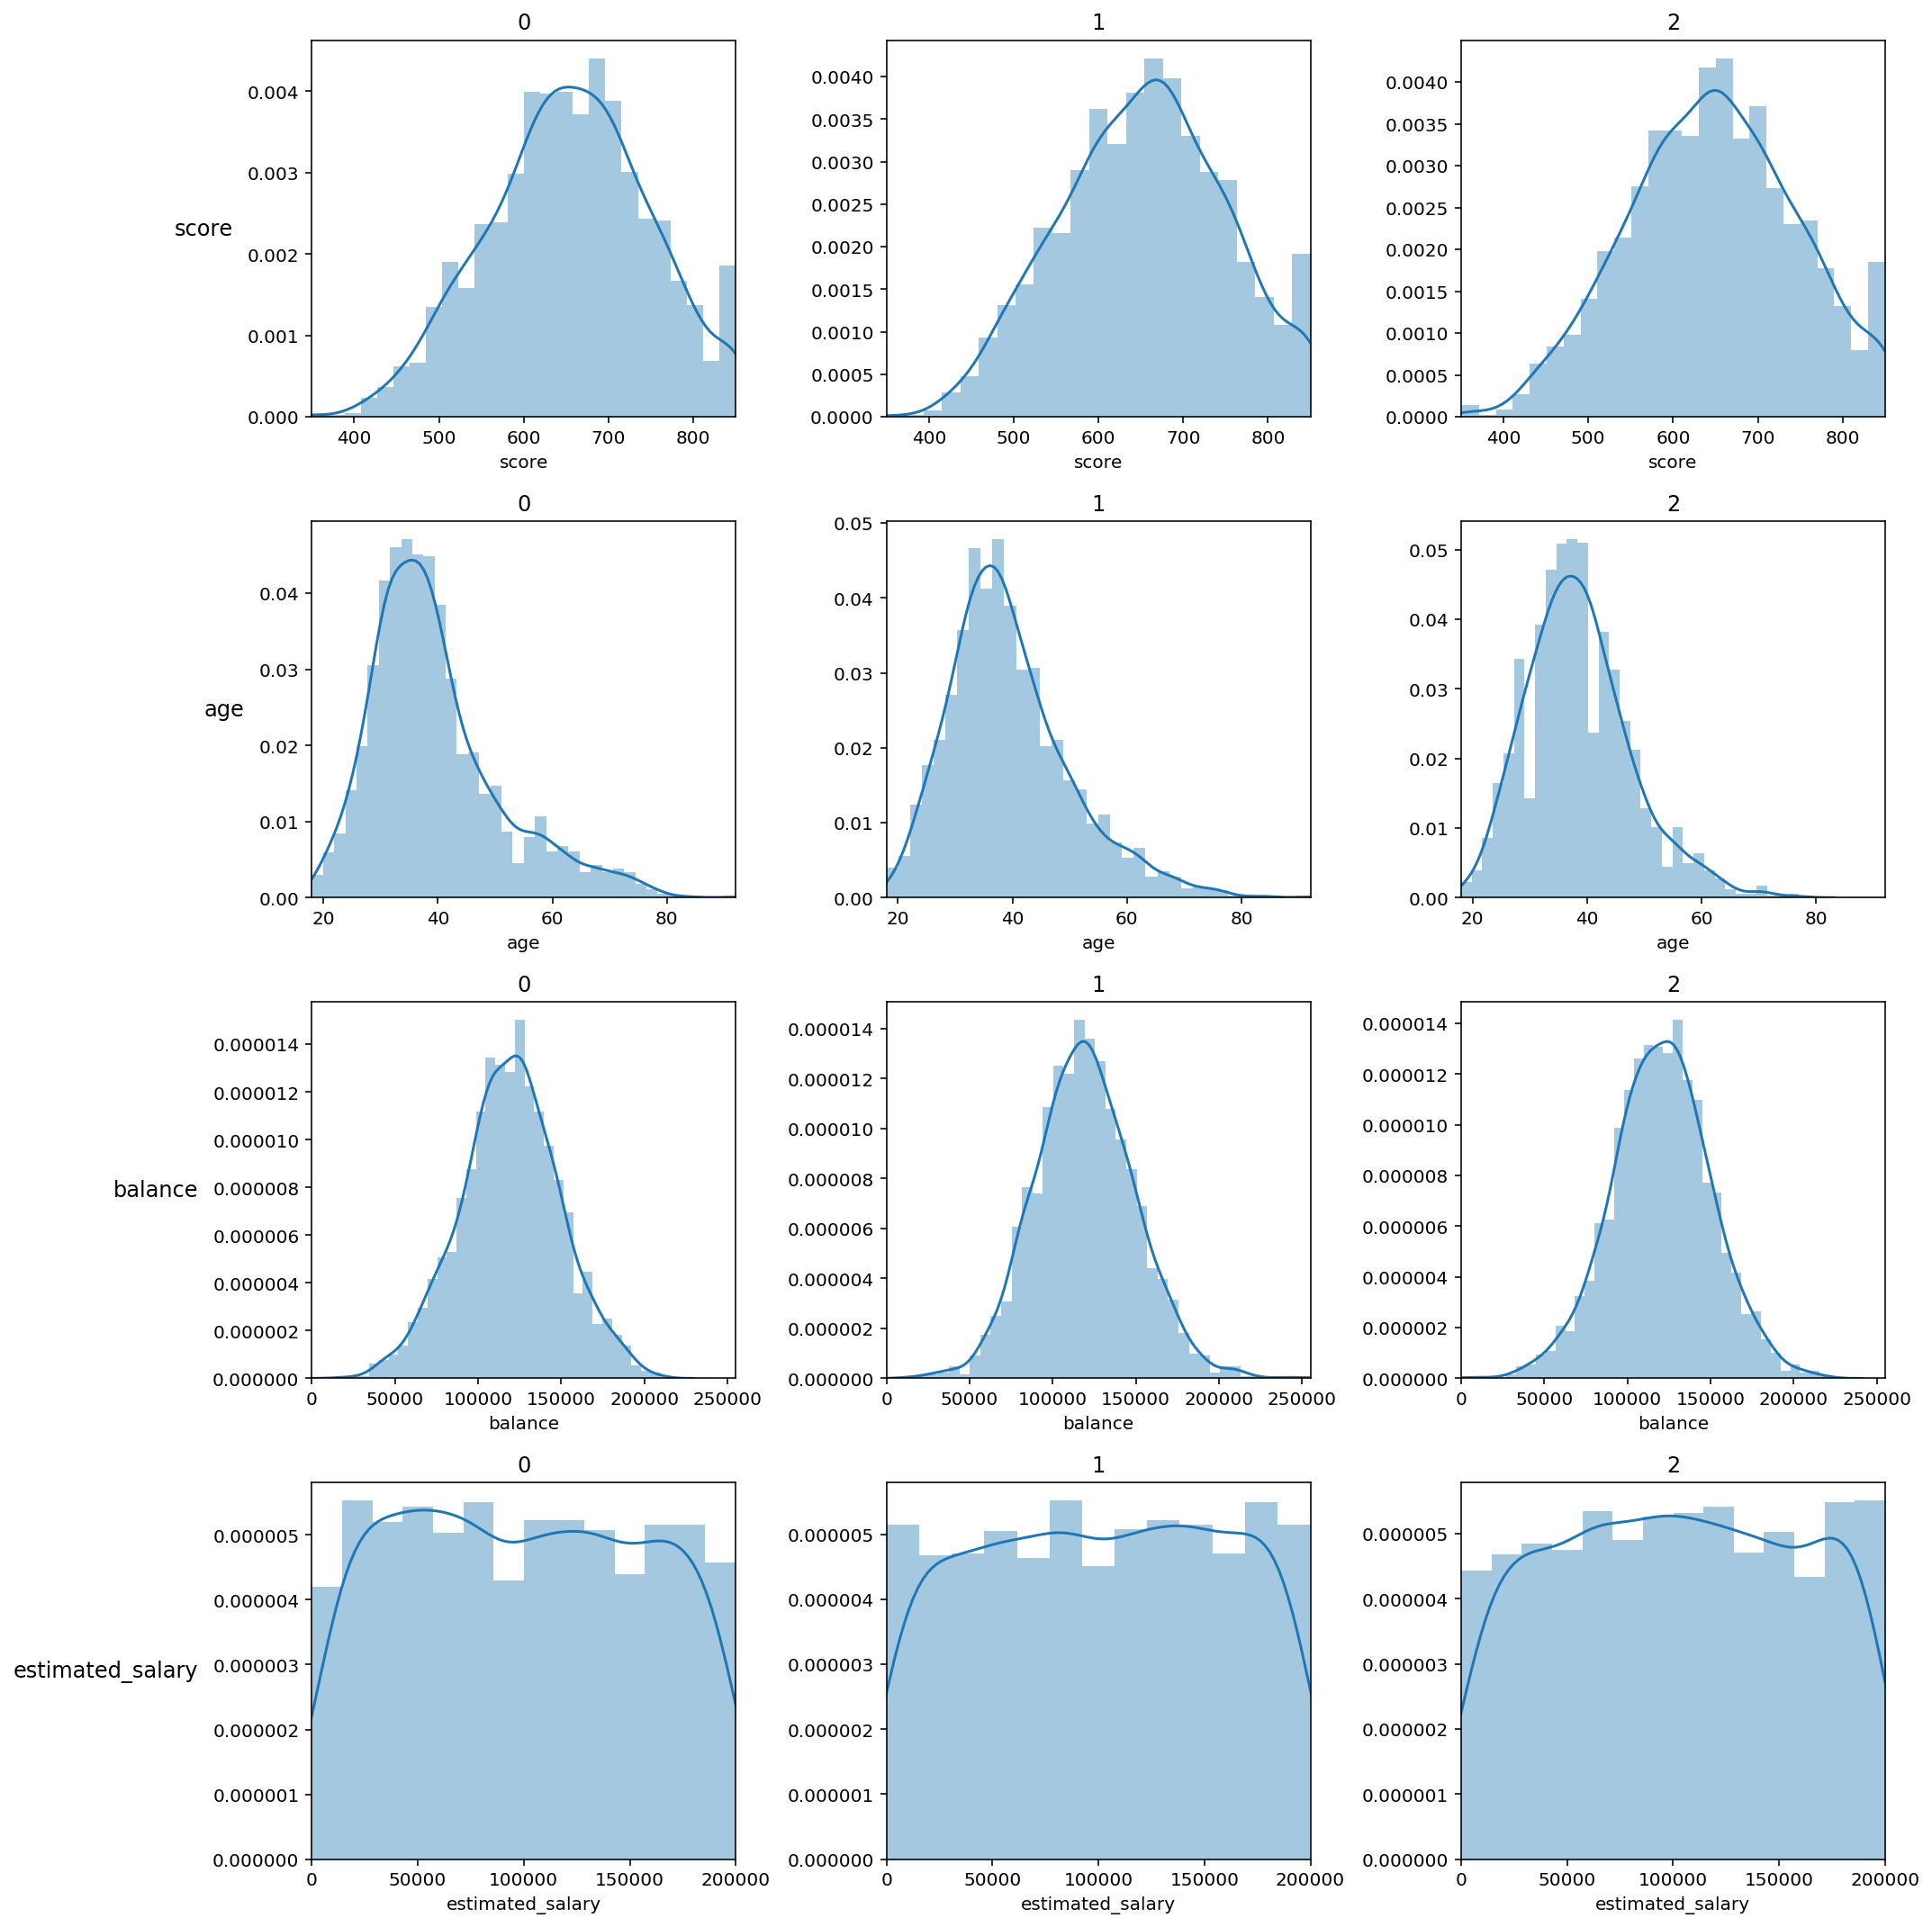

In [40]:
# Формирование списка признаков
num_features = ['score','age','balance','estimated_salary']

# Построение гистограмм
fig, axes = plt.subplots(4, 3)
xlimits = [[350, 850],[18, 92],[0, 255000],[0, 200000]]
i=0
for col in num_features:
    for k in range(3):
        axes[i][k].set_xlim(xlimits[i])
        sns.distplot(train_data[train_data['cluster_client']==k][col], ax=axes[i][k])
        axes[i][k].set_title(k)
    i+=1
for ax, row in zip(axes[:,0], num_features):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
plt.show()

В целом гистограммы выглядят очень похожими. Построим столбчатые диаграммы по остальным признакам.

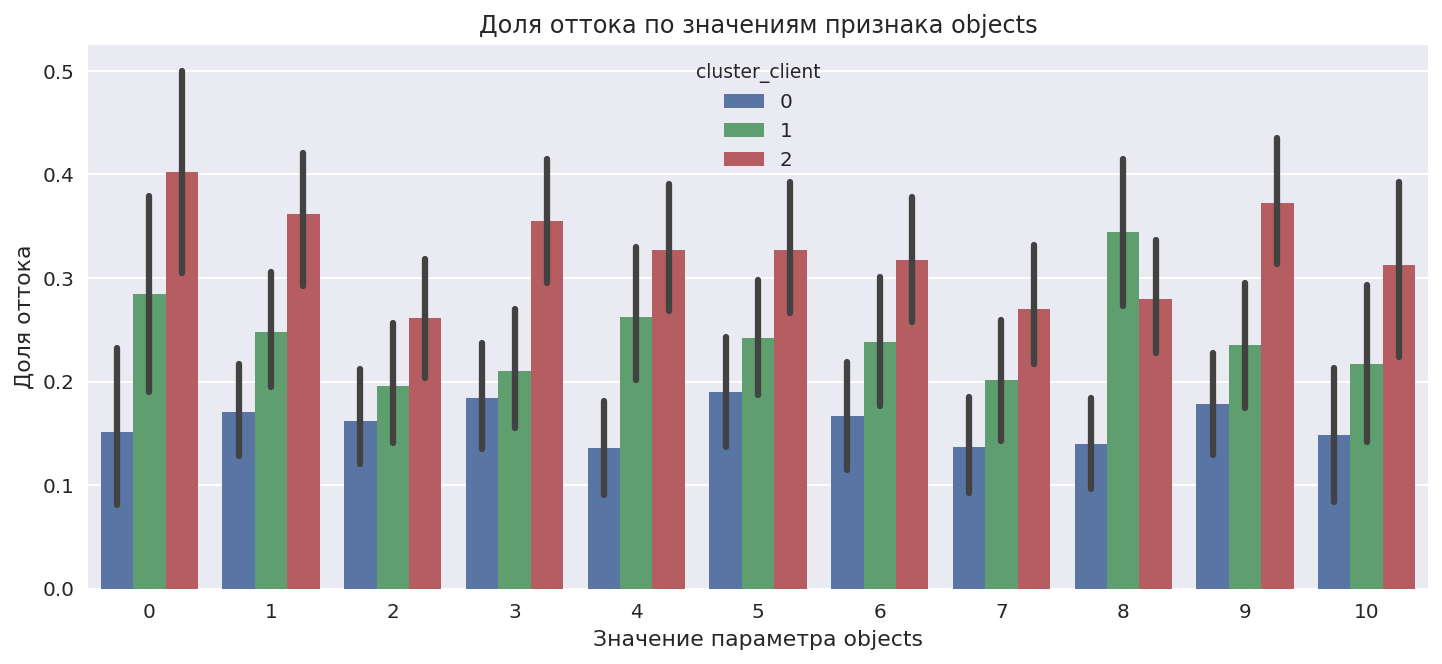

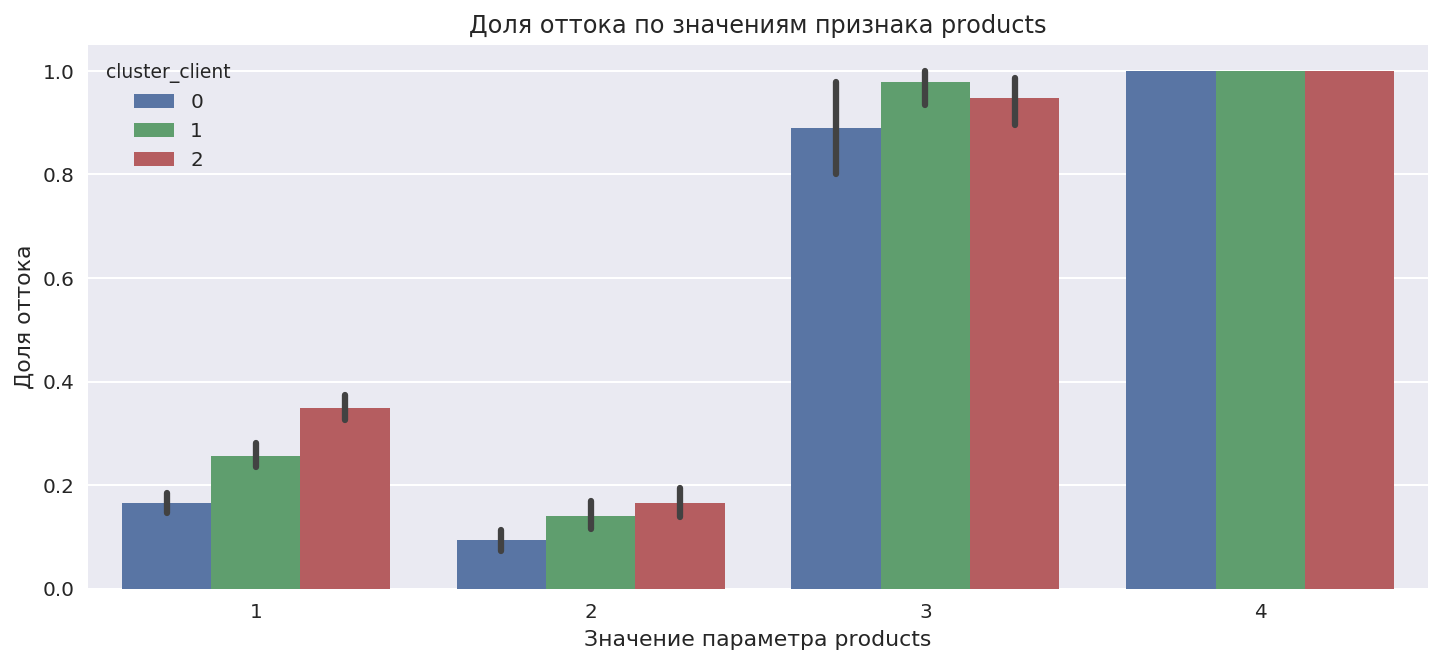

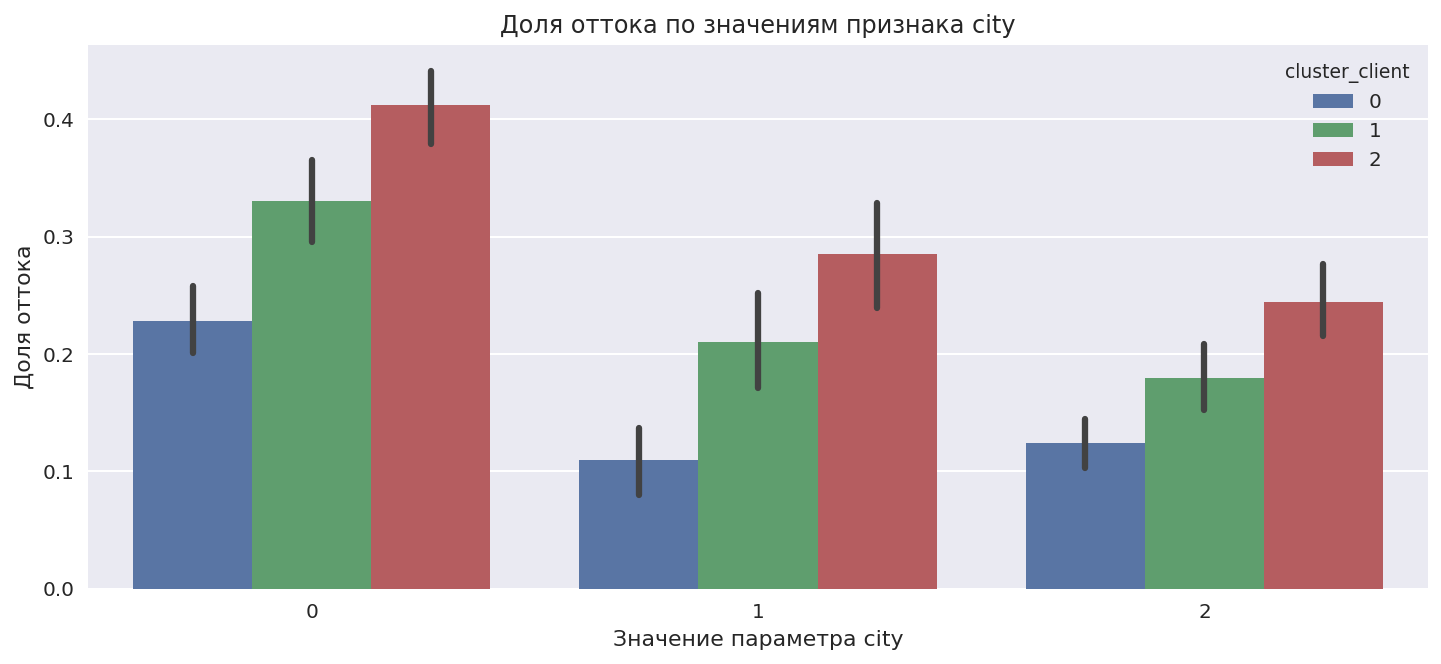

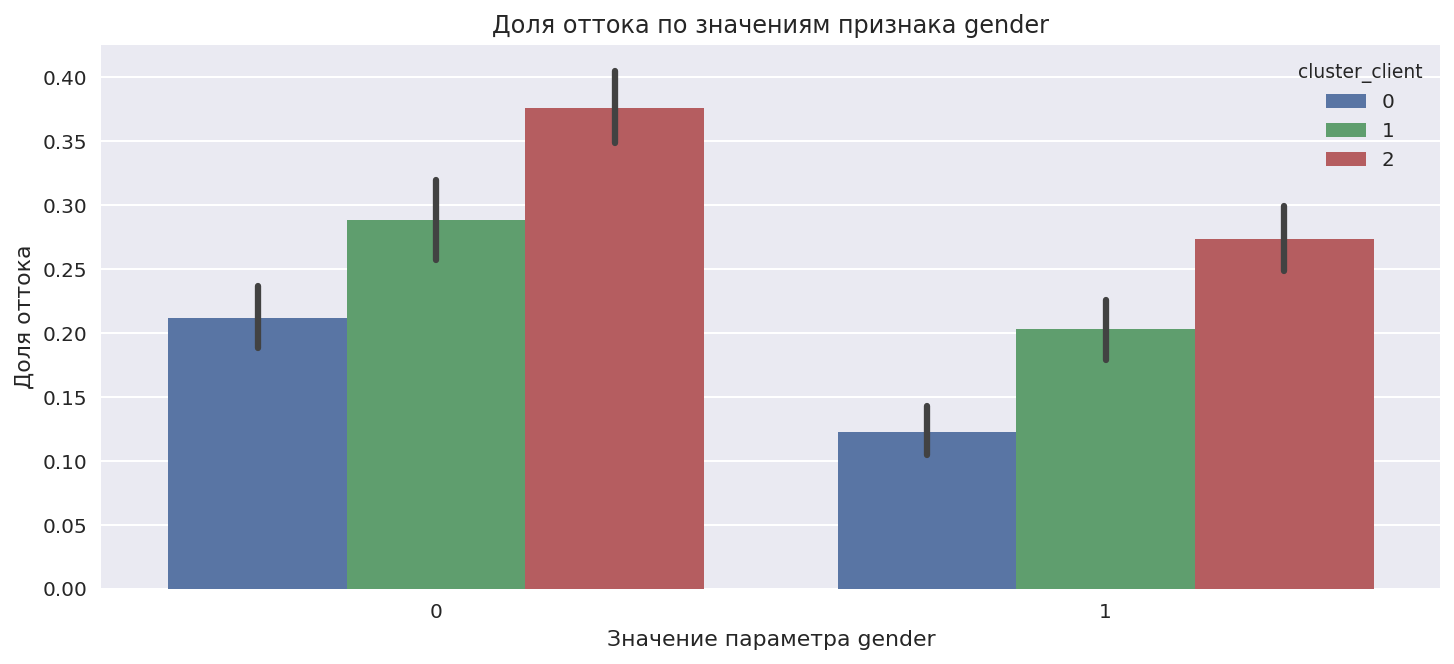

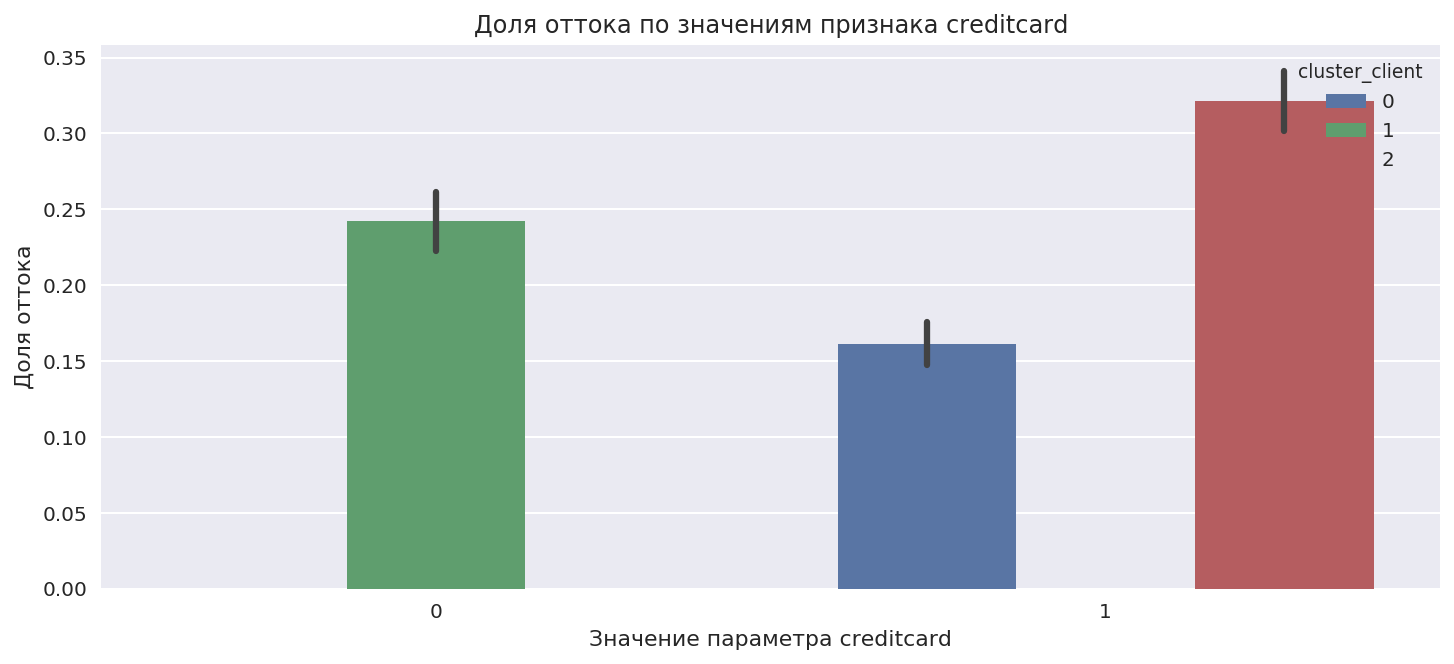

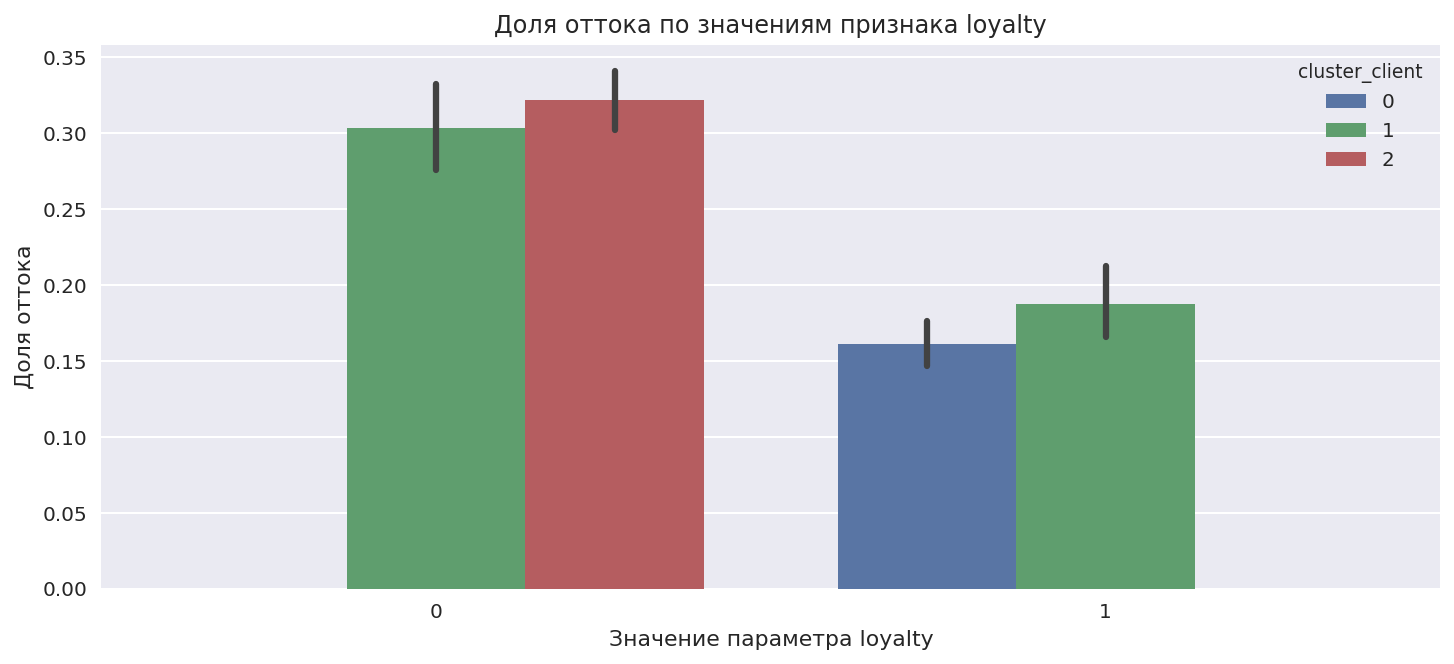

In [41]:
cat_features = ['objects','products','city','gender','creditcard', 'loyalty']

for col in cat_features:
    plt.figure(figsize=(12,5))
    with plt.style.context('seaborn'):
        ax = sns.barplot(x=col, y='churn', hue='cluster_client', data=train_data)
    plt.title('Доля оттока по значениям признака {}'.format(col))
    plt.xlabel('Значение параметра {}'.format(col))
    plt.ylabel('Доля оттока')    
    plt.show()

Глядя на данные диаграммы, можно снова отметить параметры, выделенные алгоритмом в качестве базовых для выделения кластеров:
* активность клиента
* наличие кредитной карты

Признак наличия кредитной карты ранее не был замечен в качестве влияющего на отток.

Чтобы наглядно посмотреть взаимовлияение признаков, построим диаграммы с тремя признаками сразу:
* активность клиента
* наличие кредитной карты
* пол

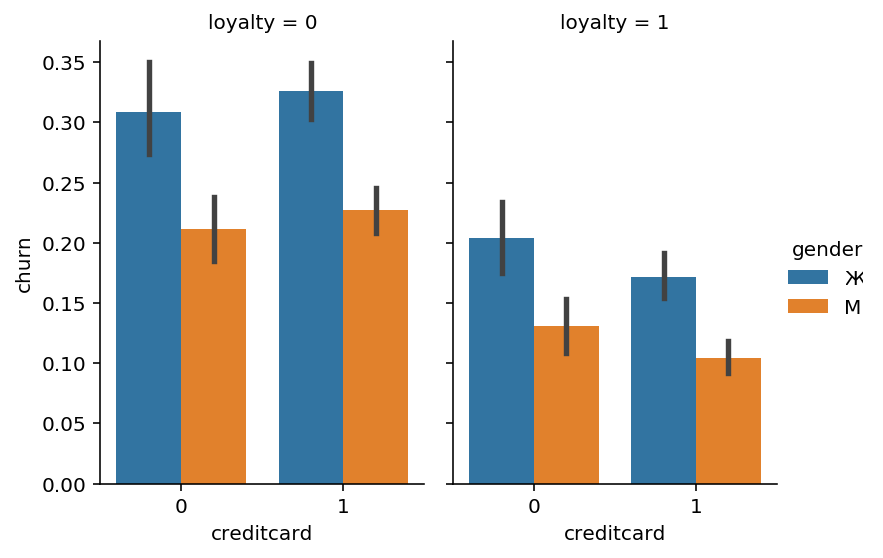

In [42]:
sns.catplot(x="creditcard", y="churn", hue="gender", col="loyalty", data=df, kind="bar", height=4, aspect=.7);

Здесь хорошо видно, как с изменение признака меняется отток клиентов. Например, минимальному оттоку соответствуют клиенты:
* активные;
* с кредитной картой;
* мужского пола.

Наибольшему оттоку клиентов соответствуют*
* неактивные;
* с кредитной картой;
* женского пола.

По наличию кредитной карты имеется следующее наблюдение: наличие кредитной карты позволяет снизить отток только если клиент активен. Если же клиент неактивен, то наличие кредитной карты способствует его уходу из банка. 

### Выводы по шагу 5
На основе проведенной кластеризации выявлен дополнительный признак, влияющий на отток: наличие кредитной карты у клиента. Причем кредитная карта показывает как снижение оттока, так и его повышение. Это зависит от активности клиента: если он активен (т.е. часто пользуется кредитной картой), то отток меньше, если неактивен, то отток выше.

## 6. Выводы<a class="anchor" id="h1_6"></a>
На основе проведенного анализа можно предложить несколько принципов для стратегии взаимодействия с клиентами и их удержания:
* способствовать проявлению активности клиентов;
* активным клиентам предлагать пользоваться кредитными картами;
* предлагать клиентам 2 самых распространенных продукта и не спешить предлагать 2 наименее распространенных;
* привлекать клиентов мужского пола, т.к. они значительно меньше уходят в отток;
* ориентироваться на клиентов со средним возрастом 45 лет.

Также можно предложеить следующие рекомендации коллегам из банка:
* Выяснить, почему клиенты при наличии 3 или 4 продуктов так сильно склонны к оттоку. Например, можно было бы собрать данные по тому, какими продуктами пользуются клиенты. Возможно это дало бы ответ на вопрос, почему при пользовании 3 или 4 продуктов вероятность оттока так сильно увеличивается.
* Коллегом из Ростова Великого обратить внимание на опыт коллег из Ярославля и Рыбинска: отток клиентов из этих двух городов значительно меньше.